## Load in a single file of json, kdst and compare event by event

In [1]:
from time import time
t0 = time()
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
runno = '7479'

In [3]:
def ndigit(j, n):
    j = str(j)
    while len(j) < n:
        j = '0' + j
    return j

In [4]:
def printtime(message = ''):
    print(message, 'Current time =', round(time() - t0, 1))

In [5]:
nfiles = 100
all_kdst_filenames = [ '/Volumes/NEXT_data/IC_Data/kdst/7479/kdst_'+ndigit(i, 4)+'_7479_trigger1_v1.1.0_20190801_autotrigger.h5' for i in range(nfiles) ]
all_json_filenames = [ '/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/variable_window_json_updated_20201222_r7479/irene_test_out_'+ndigit(i, 4)+'.json' for i in range(nfiles) ]

In [6]:
import json as js

In [7]:
all_jsons, all_kdsts = [], []
for kdst_filename, json_filename, i in zip(all_kdst_filenames, all_json_filenames, range(len(all_json_filenames))):
    if i % 5 == 0:
        printtime('File '+str(i))
    
    kdst = pd.HDFStore(kdst_filename, 'r')
    f = open(json_filename)
    json = js.load(f)
    f.close()
    
    all_jsons.append(json)
    all_kdsts.append(kdst)
printtime('End all files.')

File 0 Current time = 3.6
File 5 Current time = 11.9
File 10 Current time = 19.3
File 15 Current time = 29.9
File 20 Current time = 36.7
File 25 Current time = 43.2
File 30 Current time = 58.0
File 35 Current time = 64.5
File 40 Current time = 71.1
File 45 Current time = 98.6
File 50 Current time = 104.9
File 55 Current time = 111.4
File 60 Current time = 148.4
File 65 Current time = 155.4
File 70 Current time = 161.7
File 75 Current time = 211.6
File 80 Current time = 218.4
File 85 Current time = 224.9
File 90 Current time = 231.6
File 95 Current time = 297.5
End all files. Current time = 303.9


In [8]:
file_evts = []
for json in all_jsons:
    evts = {}
    for i, evt in zip(range(len(json['event_numbers'])), json['event_numbers']):
        evts[evt] = {'X': json['events_window_maxX'][i][-1], 'Y' : json['events_window_maxY'][i][-1], 'E': json['events_window_energy'][i][-1]}
    file_evts.append(evts)

In [9]:
offsets = []
for kdst, json, evts in zip(all_kdsts, all_jsons, file_evts):
    agree_max = 0
    offset = None
    for test_offset in range(kdst['DST/Events']['event'][0] - 20, kdst['DST/Events']['event'][0]):
        agree = 0
        disagree = 0
        checked = 0
        checkmax = 10
        for event, x, y, e in zip(kdst['DST/Events'].event, kdst['DST/Events'].X, kdst['DST/Events'].Y, kdst['DST/Events'].S2e):
            if checked >= checkmax:
                continue
            checked += 1
            if (event-1-test_offset) in json['event_numbers']:
                dx = x - evts[event-1-test_offset]['X']
                dy = y - evts[event-1-test_offset]['Y']
                de = e - evts[event-1-test_offset]['E']
                if abs(dx) < 20 and abs(dy) < 20 and abs(de) / e < 0.15:
                    agree += 1
                else:
                    disagree += 1
        if agree > agree_max:
            agree_max = agree
            offset = test_offset
    print('Offset determined:', offset, 'with', agree_max, 'agreements')
    offsets.append(offset)

Offset determined: 0 with 8 agreements
Offset determined: 346 with 9 agreements
Offset determined: 692 with 9 agreements
Offset determined: 1038 with 7 agreements
Offset determined: 1384 with 8 agreements
Offset determined: 1730 with 9 agreements
Offset determined: 2076 with 10 agreements
Offset determined: 2422 with 8 agreements
Offset determined: 2768 with 9 agreements
Offset determined: 3114 with 8 agreements
Offset determined: 3460 with 7 agreements
Offset determined: 3806 with 7 agreements
Offset determined: 4152 with 9 agreements
Offset determined: 4498 with 10 agreements
Offset determined: 4844 with 4 agreements
Offset determined: 5190 with 8 agreements
Offset determined: 5536 with 6 agreements
Offset determined: 5882 with 4 agreements
Offset determined: 6228 with 8 agreements
Offset determined: 6574 with 8 agreements
Offset determined: 6920 with 8 agreements
Offset determined: 7266 with 7 agreements
Offset determined: 7612 with 8 agreements
Offset determined: 7958 with 6 agreem

In [10]:
agree = 0
disagree = 0
dxs, dys = [], []
disagree_evts = {}
disagree_kdst_Es = []
shown = 0
showmax = 150
for kdst, json, evts, offset in zip(all_kdsts, all_jsons, file_evts, offsets):
    for event, x, y, e in zip(kdst['DST/Events'].event, kdst['DST/Events'].X, kdst['DST/Events'].Y, kdst['DST/Events'].S2e):

        if (event-1-offset) in json['event_numbers']:

            dx = x - evts[event-1-offset]['X']
            dy = y - evts[event-1-offset]['Y']
            de = e - evts[event-1-offset]['E']

            if shown < showmax:
                print('Event', event, '; Shown', shown, '/', showmax)
                print('\tKDST vs JSON E =', e, ',', evts[event-1-offset]['E'])
                print('\tabs(de)/e =', round(abs(de)/e,2))
                print('\tDX =', round(dx,1))
                print('\tDY =', round(dy,1))
            if abs(dx) < 20 and abs(dy) < 20 and abs(de) / e < 0.15:
                if shown < showmax:
                    print('\tAGREE')
                agree += 1
                dxs.append(dx)
                dys.append(dy)
            else:
                if shown < showmax:
                    print('\t!!!!! DISAGREE !!!!!')
                disagree += 1
                disagree_evts[event] = evts[event-1-offset]
                disagree_kdst_Es.append(e)
            shown += 1

Event 1 ; Shown 0 / 150
	KDST vs JSON E = 4731.38818359375 , 4835.684364869376
	abs(de)/e = 0.02
	DX = -4.1
	DY = 4.9
	AGREE
Event 5 ; Shown 1 / 150
	KDST vs JSON E = 60826.30859375 , 60354.90525564048
	abs(de)/e = 0.01
	DX = 4.2
	DY = -1.3
	AGREE
Event 8 ; Shown 2 / 150
	KDST vs JSON E = 6616.0703125 , 9169.804876118167
	abs(de)/e = 0.39
	DX = 345.7
	DY = -57.0
	!!!!! DISAGREE !!!!!
Event 8 ; Shown 3 / 150
	KDST vs JSON E = 9089.0810546875 , 9169.804876118167
	abs(de)/e = 0.01
	DX = -2.9
	DY = 1.3
	AGREE
Event 17 ; Shown 4 / 150
	KDST vs JSON E = 8322.09765625 , 8439.294384255873
	abs(de)/e = 0.01
	DX = -0.9
	DY = -0.1
	AGREE
Event 23 ; Shown 5 / 150
	KDST vs JSON E = 7323.296875 , 7360.169016025853
	abs(de)/e = 0.01
	DX = 5.2
	DY = -2.6
	AGREE
Event 24 ; Shown 6 / 150
	KDST vs JSON E = 10738.4873046875 , 10822.962959900467
	abs(de)/e = 0.01
	DX = -0.1
	DY = 0.6
	AGREE
Event 25 ; Shown 7 / 150
	KDST vs JSON E = 11222.7080078125 , 11288.142143809677
	abs(de)/e = 0.01
	DX = 2.6
	DY = -5

Event 352 ; Shown 96 / 150
	KDST vs JSON E = 9979.763671875 , 10084.038552735388
	abs(de)/e = 0.01
	DX = 0.4
	DY = 2.1
	AGREE
Event 354 ; Shown 97 / 150
	KDST vs JSON E = 7583.37744140625 , 7634.822056749511
	abs(de)/e = 0.01
	DX = -5.9
	DY = 3.2
	AGREE
Event 354 ; Shown 98 / 150
	KDST vs JSON E = 7949.5859375 , 7634.822056749511
	abs(de)/e = 0.04
	DX = 64.7
	DY = 65.0
	!!!!! DISAGREE !!!!!
Event 355 ; Shown 99 / 150
	KDST vs JSON E = 12045.1962890625 , 12116.996410121781
	abs(de)/e = 0.01
	DX = -1.7
	DY = -4.6
	AGREE
Event 358 ; Shown 100 / 150
	KDST vs JSON E = 11509.03515625 , 11572.406985622967
	abs(de)/e = 0.01
	DX = 5.6
	DY = -5.2
	AGREE
Event 360 ; Shown 101 / 150
	KDST vs JSON E = 11491.2177734375 , 11614.18577840147
	abs(de)/e = 0.01
	DX = 1.5
	DY = -7.5
	AGREE
Event 361 ; Shown 102 / 150
	KDST vs JSON E = 23650.056640625 , 23729.834285962304
	abs(de)/e = 0.0
	DX = -3.2
	DY = -0.4
	AGREE
Event 367 ; Shown 103 / 150
	KDST vs JSON E = 11183.1923828125 , 11267.81136479657
	abs(de

In [11]:
print('Agree =', agree, '; Disagree =', disagree)

Agree = 8229 ; Disagree = 2182


In [12]:
all_kdst_S2e = np.array([])
all_json_S2e = np.array([])
for kdst, json in zip(all_kdsts, all_jsons):
    all_kdst_S2e = np.append(all_kdst_S2e, kdst['DST/Events'].S2e)
    json_energy = np.array([ evt[-1] for evt in json['events_window_energy'] ])
    all_json_S2e = np.append(all_json_S2e, json_energy)

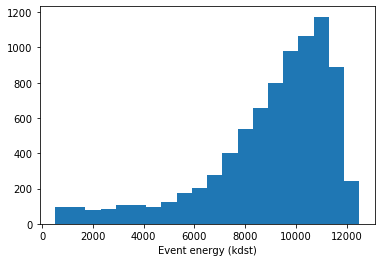

In [13]:
plt.hist(all_kdst_S2e, range = (500, 12500), bins = 20)
plt.xlabel('Event energy (kdst)')
plt.show()

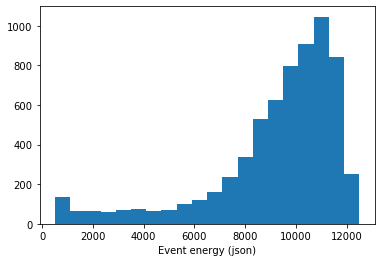

In [14]:
plt.hist(all_json_S2e, range = (500, 12500), bins = 20)
plt.xlabel('Event energy (json)')
plt.show()

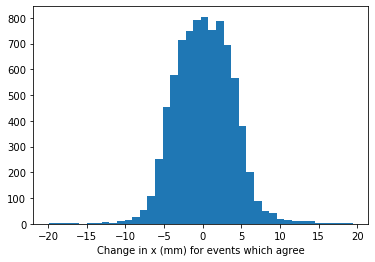

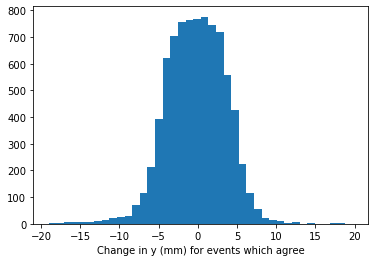

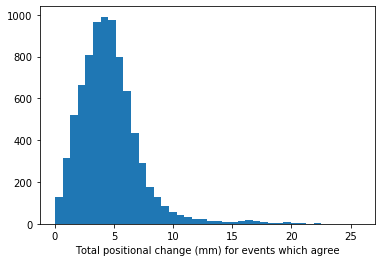

In [15]:
plt.hist(dxs, bins = 40)
plt.xlabel('Change in x (mm) for events which agree')
plt.show()

plt.hist(dys, bins = 40)
plt.xlabel('Change in y (mm) for events which agree')
plt.show()

drs = (np.array(dxs)**2 + np.array(dys)**2)**0.5
plt.hist(drs, bins = 40)
plt.xlabel('Total positional change (mm) for events which agree')
plt.show()

In [16]:
printtime()

 Current time = 590.6


## Look at events selected out of kdst

In [17]:
# Just uses single file info for now
kdst = all_kdsts[0]
json = all_jsons[0]
evts = file_evts[0]

In [18]:
kdst_sel_nums = np.array(kdst['DST/Events'].event)
# kdst_missing = np.zeros(len(evts), dtype='bool') # these are indexed to match evts
missing_evts = {}
for i in range(len(evts)):
    if i+1 not in kdst_sel_nums and i in evts.keys():
        missing_evts[i] = evts[i]
        # kdst_missing[i] = True

In [19]:
missing_evts

{1: {'X': 95.0, 'Y': -45.0, 'E': 72.75869348407505},
 2: {'X': -65.0, 'Y': -205.0, 'E': 99.41556463108478},
 3: {'X': -235.0, 'Y': 45.0, 'E': 96.30852683823178},
 5: {'X': 215.0, 'Y': -115.0, 'E': 93.76776254162165},
 6: {'X': -235.0, 'Y': 45.0, 'E': 77.51025356349471},
 8: {'X': -235.0, 'Y': 45.0, 'E': 31.13005681803999},
 9: {'X': 85.0, 'Y': 65.0, 'E': 90.62840125309528},
 10: {'X': -15.0, 'Y': 235.0, 'E': 281.4791583157921},
 11: {'X': 85.0, 'Y': 195.0, 'E': 45.85289334621182},
 12: {'X': -235.0, 'Y': 45.0, 'E': 99.82771159050975},
 13: {'X': -235.0, 'Y': 45.0, 'E': 82.25117011458293},
 14: {'X': 65.0, 'Y': 35.0, 'E': 86.54373285292364},
 15: {'X': 85.0, 'Y': 65.0, 'E': 77.36995850902473},
 17: {'X': -65.0, 'Y': -205.0, 'E': 15.512291150885515},
 18: {'X': -235.0, 'Y': 45.0, 'E': 70.4418000191474},
 19: {'X': 55.0, 'Y': -15.0, 'E': 50.145403396920635},
 20: {'X': -235.0, 'Y': 45.0, 'E': 72.89686328332084},
 21: {'X': -65.0, 'Y': -205.0, 'E': 92.7222610766369},
 25: {'X': 85.0, 'Y': 

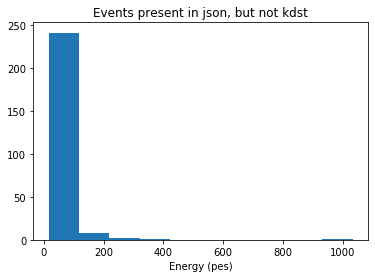

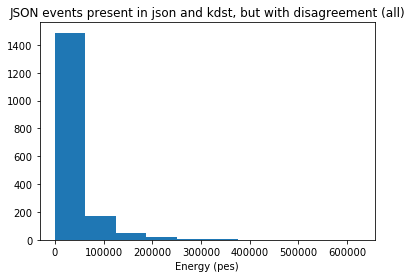

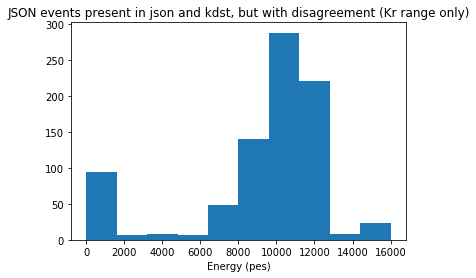

In [20]:
missingEs = [ missing_evts[i]['E'] for i in missing_evts.keys() ]
plt.hist(missingEs)
plt.xlabel('Energy (pes)')
plt.title('Events present in json, but not kdst')
plt.show()

disagreeEs = [ disagree_evts[i]['E'] for i in disagree_evts.keys() ]
plt.hist(disagreeEs)
plt.xlabel('Energy (pes)')
plt.title('JSON events present in json and kdst, but with disagreement (all)')
plt.show()

plt.hist(disagreeEs, range = (0, 16000))
plt.xlabel('Energy (pes)')
plt.title('JSON events present in json and kdst, but with disagreement (Kr range only)')
plt.show()

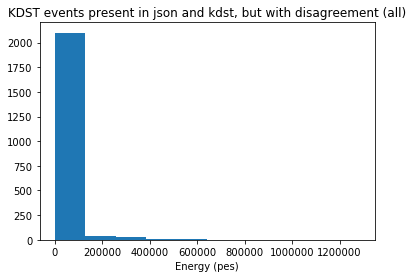

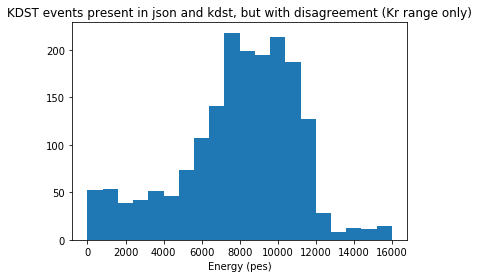

In [21]:
plt.hist(disagree_kdst_Es)
plt.xlabel('Energy (pes)')
plt.title('KDST events present in json and kdst, but with disagreement (all)')
plt.show()

plt.hist(disagree_kdst_Es, range = (0, 16000), bins = 20)
plt.xlabel('Energy (pes)')
plt.title('KDST events present in json and kdst, but with disagreement (Kr range only)')
plt.show()

## Load in several kdsts to get corrected spectrum

In [22]:
nkdst = 2000
kdst_filenames = [ '/Volumes/NEXT_data/IC_Data/kdst/7479/kdst_'+ndigit(i, 4)+'_7479_trigger1_v1.1.0_20190801_autotrigger.h5' for i in range(nkdst) ]

In [23]:
all_kdsts = None

printtime()
tstart = time()
for kfile in kdst_filenames:
    xkdst = pd.HDFStore(kfile, 'r')['DST/Events']
    if all_kdsts is None:
        all_kdsts = xkdst
    else:
        #print(all_kdsts)
        all_kdsts = all_kdsts.append(xkdst)
    #print(kdst.keys())
print('Time for', nkdst, '=', round(time() - tstart, 1))

 Current time = 592.6
Time for 2000 = 494.4


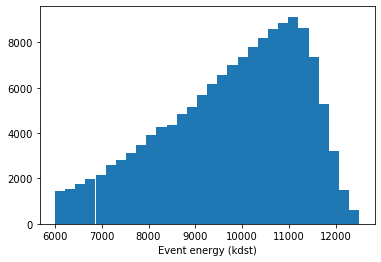

In [24]:
kdstE = np.array(all_kdsts.S2e)

plt.hist(kdstE, range = (6000, 12500), bins = 30)
plt.xlabel('Event energy (kdst)')
plt.show()

In [25]:
printtime()

 Current time = 1087.5


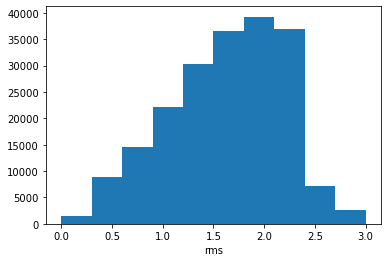

In [26]:
plt.hist(all_kdsts.Zrms, range=(0, 3))
plt.xlabel('rms')
plt.show()

In [27]:
def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

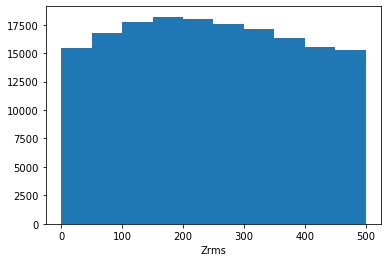

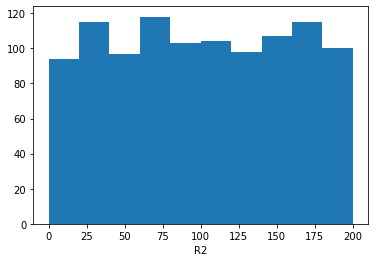

In [28]:
kdstX = np.array(all_kdsts.X)
kdstY = np.array(all_kdsts.Y)
kdstR = (kdstX**2 + kdstY**2)**0.5
Zrms = exp_dt(np.array(all_kdsts.Zrms))

plt.hist(Zrms, range=(0, 500))
plt.xlabel('Zrms')
plt.show()

plt.hist(kdstR**2, range=(0, 200))
plt.xlabel('R2')
plt.show()

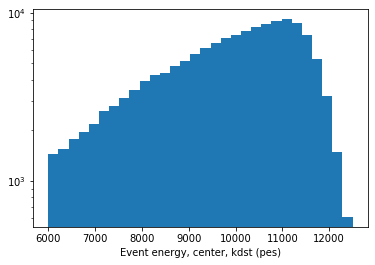

In [39]:
plt.hist(kdstE, range = (6000, 12500), bins = 30)
plt.xlabel('Event energy, center, kdst (pes)')
plt.yscale('log')
plt.show()

## Add corrections to kdsts to look for x-ray peaks

In [142]:
import h5py
import itertools as it
from scipy.optimize import curve_fit

zlims = [50, 100, 200, 300, 400, 500]
rlims = [50, 100, 150, 170]

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask, xvals, yvals, zvals, energies, ltmap = None, show = True, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 10000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = zvals[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')

def fit_res_vs_zr(energies, bounds, umask, xvals, yvals, zvals, show = True):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        mymed = np.median(energies[fidmask])
        lower = np.percentile(energies[fidmask], 50 - 68/2)
        upper = np.percentile(energies[fidmask], 50 + 68/2)
        lower = mymed - 3 * (mymed - lower)
        upper = mymed + 3 * (upper - mymed)
        h = plt.hist(energies[fidmask], range=(lower, upper), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), np.median(energies[fidmask]), np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if (zlim == zlims[0] and rlim == rlims[0]) or show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def fit_res_vs_zr_matched(energies, bounds, xvals, yvals, zvals, show = True):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals, masked_Es = xvals[xymask], yvals[xymask], zvals[xymask], energies[xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        mymed = np.median(masked_Es[fidmask])
        lower = np.percentile(masked_Es[fidmask], 50 - 68/2)
        upper = np.percentile(masked_Es[fidmask], 50 + 68/2)
        mystd = min(mymed - lower, upper - mymed)
        lower = mymed - 3 * mystd
        upper = mymed + 3 * mystd
        h = plt.hist(masked_Es[fidmask], range=(lower, upper), bins = 31)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), np.median(masked_Es[fidmask]), np.std(masked_Es[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if (zlim == zlims[0] and rlim == rlims[0]) or show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

In [41]:
import h5py
file_7472   = '/Volumes/NEXT_Data/IC_Data/st190819/maps/kr_emap_xy_50_50_r_7472_st190819.h5'
emap = h5py.File(file_7472, 'r')

In [42]:
emap['e0'].keys()

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>

In [43]:
# f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]

In [44]:
emap.keys()

<KeysViewHDF5 ['chi2', 'e0', 'e0u', 'lt', 'ltu', 'mapinfo', 'time_evolution']>

In [45]:
emap['time_evolution'].keys()

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>

In [46]:
np.array(emap['time_evolution']['block0_values'])

array([[1.56667225e+09, 1.26747922e+04, 1.53522238e+00, 7.14153315e+03,
        1.91708006e+01, 9.13562679e-01, 2.19908957e-04, 2.11242088e+02,
        1.92358550e-01, 2.09123065e+00, 2.02950218e-03, 1.07378018e+01,
        1.08511010e-02, 1.01707790e+01, 6.31263901e-03, 2.50819994e+03,
        2.68467799e+00, 1.03686252e+04, 2.73914929e+00, 5.60190847e+02,
        1.61653344e-01, 1.99861598e+01, 6.49985696e-03, 1.23133582e+01,
        1.75814289e-02, 1.24412079e+01, 1.86430319e-02],
       [1.56667574e+09, 1.26744556e+04, 1.54041190e+00, 7.16905081e+03,
        1.92795196e+01, 9.13442822e-01, 2.30757202e-04, 2.11172909e+02,
        1.93116448e-01, 2.09440531e+00, 2.03534589e-03, 1.07535364e+01,
        1.09229549e-02, 1.01729491e+01, 6.33856314e-03, 2.51070825e+03,
        2.69651111e+00, 1.03719093e+04, 2.74177314e+00, 5.60533344e+02,
        1.61662020e-01, 1.99972512e+01, 6.49775073e-03, 1.22905734e+01,
        1.74701833e-02, 1.24158436e+01, 1.86811527e-02],
       [1.56667923e+09

In [47]:
# f = h5py.File(filename, 'r')
# e0map = np.array(f['e0']['block0_values'])
# ltmap = np.array(f['lt']['block0_values'])

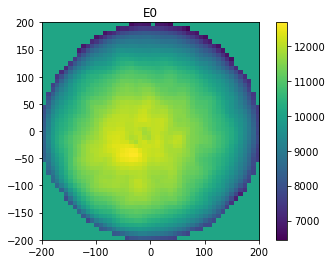

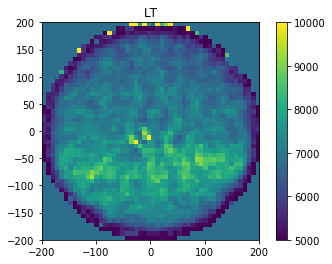

Correcting energies...
0 / 207579


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: divide by zero encountered in double_scalars


10000 / 207579
Est remaining = 86.0


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:71: RuntimeWarning: overflow encountered in double_scalars


20000 / 207579
Est remaining = 80.0
30000 / 207579
Est remaining = 75.4
40000 / 207579
Est remaining = 70.6
50000 / 207579
Est remaining = 66.3
60000 / 207579
Est remaining = 62.0
70000 / 207579
Est remaining = 62.9
80000 / 207579
Est remaining = 65.1
90000 / 207579
Est remaining = 61.1
100000 / 207579
Est remaining = 59.5
110000 / 207579
Est remaining = 55.5
120000 / 207579
Est remaining = 51.4
130000 / 207579
Est remaining = 46.2
140000 / 207579
Est remaining = 40.6
150000 / 207579
Est remaining = 35.5
160000 / 207579
Est remaining = 29.3
170000 / 207579
Est remaining = 23.3
180000 / 207579
Est remaining = 17.0
190000 / 207579
Est remaining = 10.9
200000 / 207579
Est remaining = 4.7


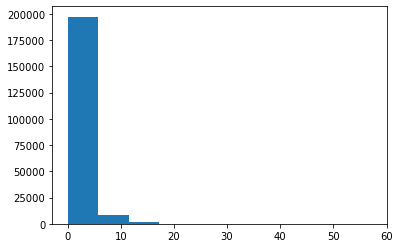

Fit a Gaussian with guess (A0, m0, s0) = (620.0, 0.9943871067416552, 2.9363070075577147)


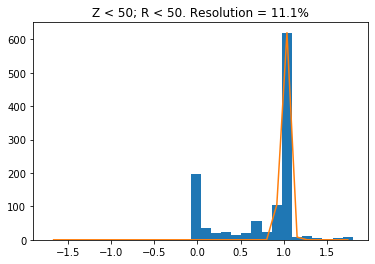

Fit a Gaussian with guess (A0, m0, s0) = (2411.0, 0.9949735907234265, 2.788817422727642)


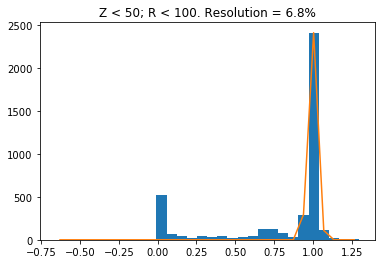

Fit a Gaussian with guess (A0, m0, s0) = (4543.0, 0.9941584417429253, 2.4958980635520414)


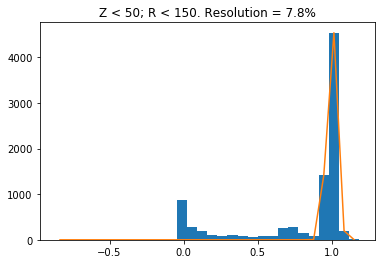

Fit a Gaussian with guess (A0, m0, s0) = (5071.0, 0.994299894223734, 2.349602878292703)


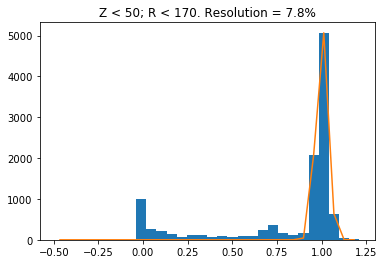

Fit a Gaussian with guess (A0, m0, s0) = (903.0, 0.9974423480733632, 2.410864425439408)


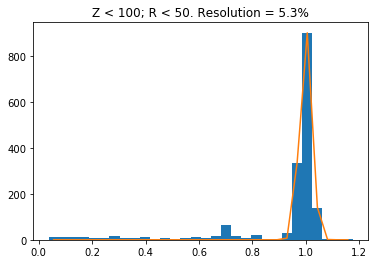

Fit a Gaussian with guess (A0, m0, s0) = (2992.0, 0.9975410270314665, 2.2256957976555922)


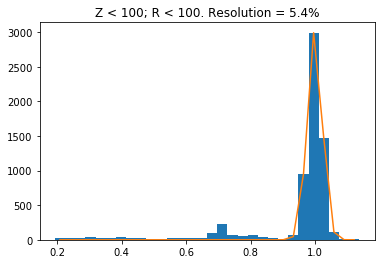

Fit a Gaussian with guess (A0, m0, s0) = (5786.0, 0.9971455978473244, 1.9759616035769858)


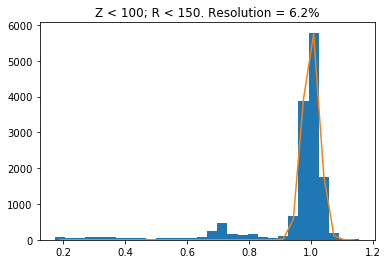

Fit a Gaussian with guess (A0, m0, s0) = (6769.0, 0.997308592800153, 1.8669495270965561)


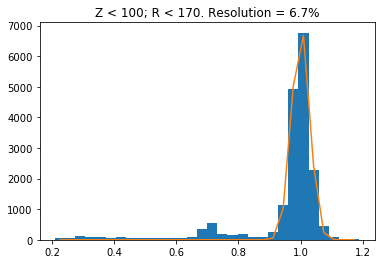

Fit a Gaussian with guess (A0, m0, s0) = (1842.0, 0.9996804420441618, 1.9826727146689944)


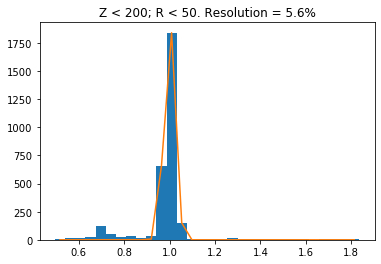

Fit a Gaussian with guess (A0, m0, s0) = (2318.0, 0.999489391955894, 1.8367660399077235)


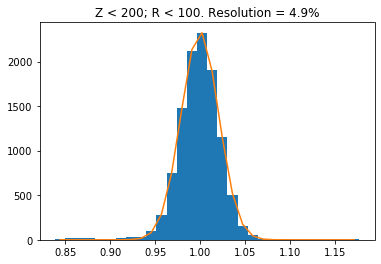

Fit a Gaussian with guess (A0, m0, s0) = (5833.0, 0.999436596108216, 1.6527919629763548)


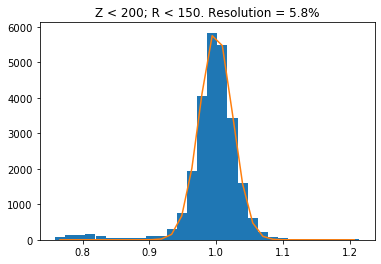

Fit a Gaussian with guess (A0, m0, s0) = (7933.0, 0.9995986384602176, 1.5735668070514692)


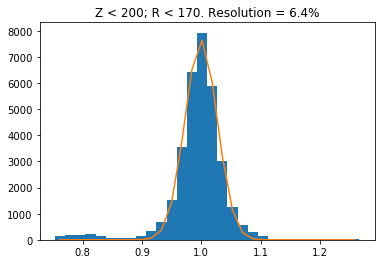

Fit a Gaussian with guess (A0, m0, s0) = (2496.0, 1.001257551922912, 1.8335541575864014)


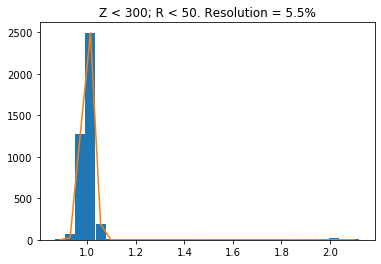

Fit a Gaussian with guess (A0, m0, s0) = (7944.0, 1.001008244392176, 1.7275005025481147)


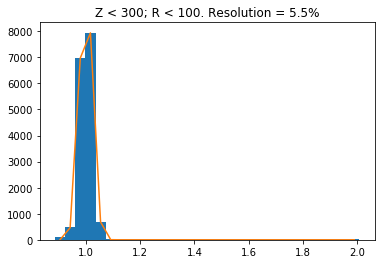

Fit a Gaussian with guess (A0, m0, s0) = (20561.0, 1.0012669804477696, 1.5780472909027385)


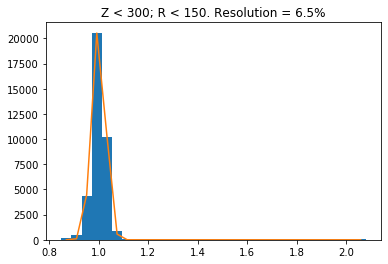

Fit a Gaussian with guess (A0, m0, s0) = (23596.0, 1.0015739774435442, 1.514498249373522)


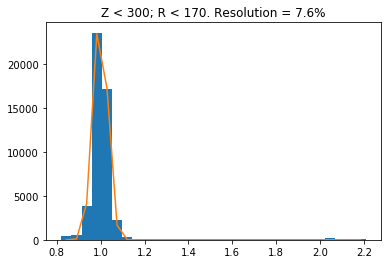

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Fit a Gaussian with guess (A0, m0, s0) = (3505.0, 1.0017761143054194, 1.8477136382252375)


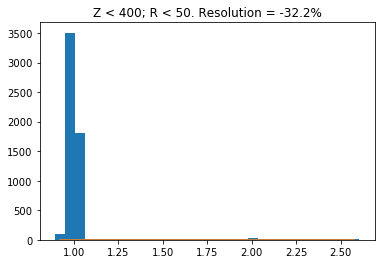

Fit a Gaussian with guess (A0, m0, s0) = (13760.0, 1.0019171489302794, 1.7026332848810768)


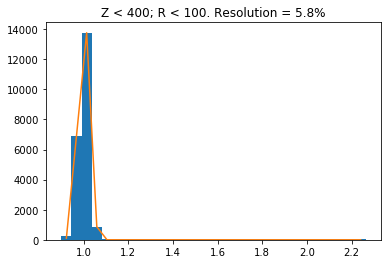

Fit a Gaussian with guess (A0, m0, s0) = (32182.0, 1.0023535565217554, 1.5700192080788056)


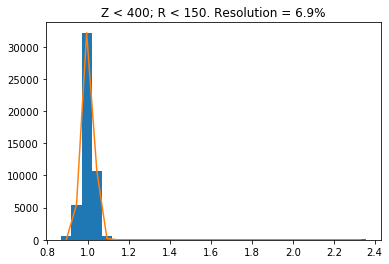

Fit a Gaussian with guess (A0, m0, s0) = (40346.0, 1.002659763060288, 1.5142787918742395)


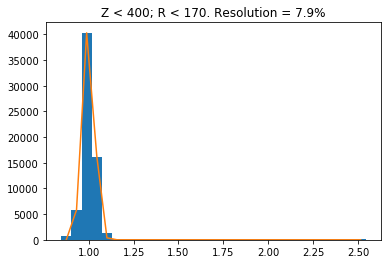

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Fit a Gaussian with guess (A0, m0, s0) = (4866.0, 1.0020593407771985, 1.8071977512149278)


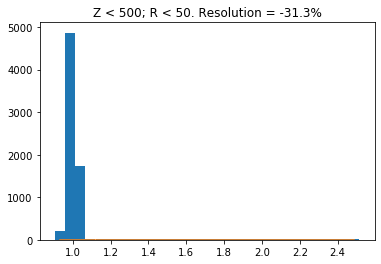

Fit a Gaussian with guess (A0, m0, s0) = (16996.0, 1.0022171788932606, 1.6826720914568083)


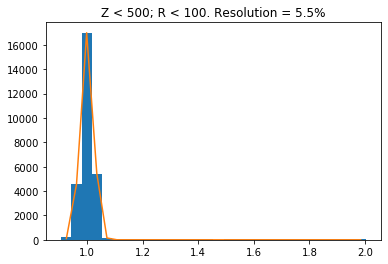

Fit a Gaussian with guess (A0, m0, s0) = (33569.0, 1.002844547634034, 1.5794155279670317)


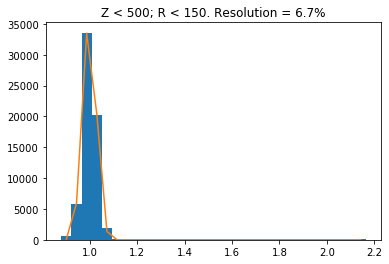

Fit a Gaussian with guess (A0, m0, s0) = (43726.0, 1.0032474700847374, 1.5340530285907272)


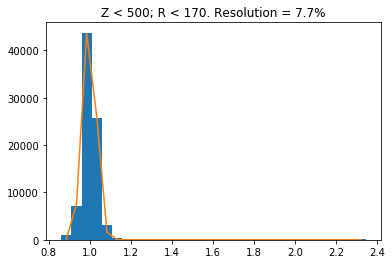

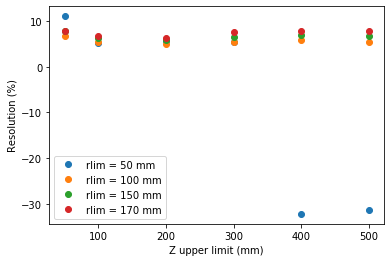

Innermost resolution =  11.06 %
Outermost resolution =  7.73 %


In [48]:
file_7472   = '/Volumes/NEXT_Data/IC_Data/st190819/maps/kr_emap_xy_50_50_r_7472_st190819.h5'

zlimtest = 100
rlimtest = 50
zrmask = (Zrms < zlimtest) & (kdstR < rlimtest)
nomask = np.ones(len(kdstE), dtype='bool')

e0_7472, lt_7472, bounds_7472 = load_maps_from_file(file_7472)
r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, nomask, kdstX, kdstY, Zrms, kdstE, ltmap = lt_7472, vocal = True)
r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, bounds_7472, nomask, kdstX, kdstY, Zrms, show = True)
plot_res_vs_zr(r7472_res_vs_zr)

In [49]:
kdstN = np.array(all_kdsts.event)
doubles = []
for n, i in zip(kdstN[:-2], range(len(kdstN)-1)):
    if i % 10000 == 0:
        print(i, '/', len(kdstN))
    if kdstN[i+1] == kdstN[i]:
        doubles.append(n)
doubles = np.unique(np.array(doubles))

0 / 210221
10000 / 210221
20000 / 210221
30000 / 210221
40000 / 210221
50000 / 210221
60000 / 210221
70000 / 210221
80000 / 210221
90000 / 210221
100000 / 210221
110000 / 210221
120000 / 210221
130000 / 210221
140000 / 210221
150000 / 210221
160000 / 210221
170000 / 210221
180000 / 210221
190000 / 210221
200000 / 210221
210000 / 210221


In [50]:
doubles

array([     8,     28,     91, ..., 691929, 691984, 691994], dtype=int32)

In [51]:
is_double = np.array([ n in doubles for n in kdstN ])

In [52]:
kdst_bootcor_energies = r7472_scaled_energy * 41.5

In [53]:
xymask = (abs(kdstY) < 200) & (abs(kdstX) < 200)
zr_cor_mask = (Zrms[xymask] < zlimtest) & (kdstR[xymask] < rlimtest)

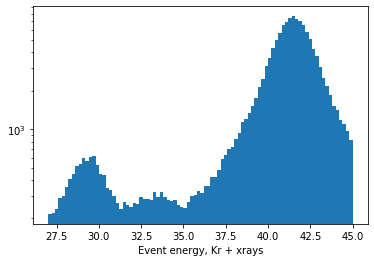

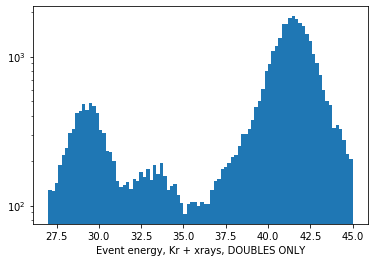

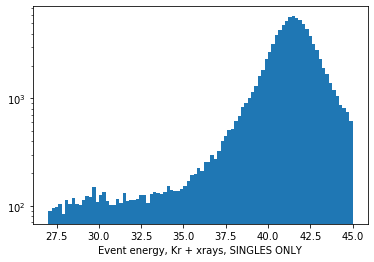

In [54]:
plt.hist(kdst_bootcor_energies, range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy, Kr + xrays')
plt.show()

plt.hist(kdst_bootcor_energies[is_double[xymask]], range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy, Kr + xrays, DOUBLES ONLY')
plt.show()

plt.hist(kdst_bootcor_energies[~is_double[xymask]], range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy, Kr + xrays, SINGLES ONLY')
plt.show()

## Add corrections to jsons to look for x-ray peaks

In [55]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_json = js.load(f)
f.close()

In [56]:
histat_json.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [57]:
hiX, hiY, hiZ, hiE = np.array(histat_json['events_X_sipm_subtracted']), np.array(histat_json['events_Y_sipm_subtracted']), np.array(histat_json['all_Zrms']), np.array(histat_json['events_energy'])

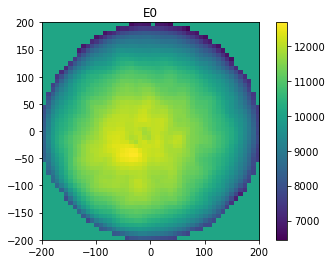

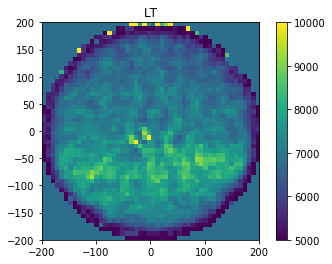

Correcting energies...
0 / 121327
10000 / 121327
Est remaining = 397.5
20000 / 121327
Est remaining = 383.1
30000 / 121327
Est remaining = 357.9
40000 / 121327
Est remaining = 331.6
50000 / 121327
Est remaining = 295.1
60000 / 121327
Est remaining = 255.8
70000 / 121327
Est remaining = 214.5
80000 / 121327
Est remaining = 173.6
90000 / 121327
Est remaining = 132.9
100000 / 121327
Est remaining = 90.9
110000 / 121327
Est remaining = 48.3
120000 / 121327
Est remaining = 5.7


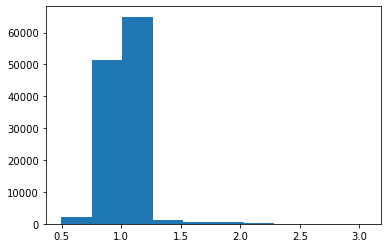

Fit a Gaussian with guess (A0, m0, s0) = (47.0, 1.0061321024381515, 0.08677507980912781)


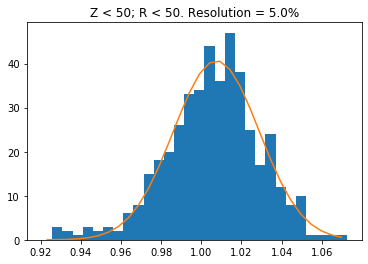

Fit a Gaussian with guess (A0, m0, s0) = (172.0, 1.0052223171659602, 0.08122324837298811)


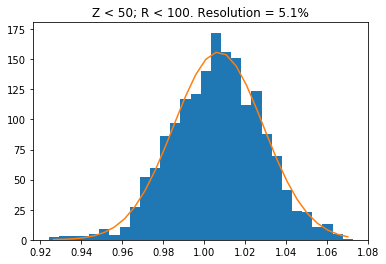

Fit a Gaussian with guess (A0, m0, s0) = (357.0, 1.0057959316503673, 0.08111291920911974)


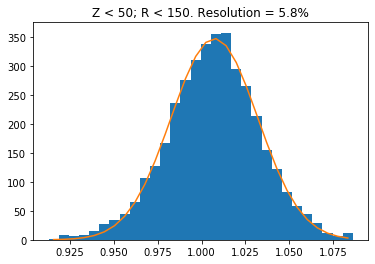

Fit a Gaussian with guess (A0, m0, s0) = (443.0, 1.0060047554480986, 0.08333209805923385)


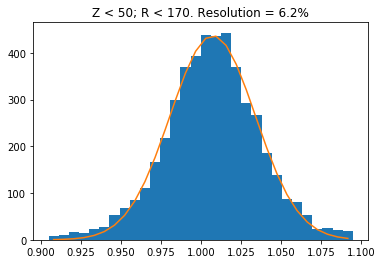

Fit a Gaussian with guess (A0, m0, s0) = (107.0, 1.0077403913662986, 0.06871790675599647)


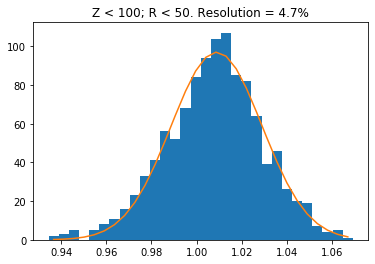

Fit a Gaussian with guess (A0, m0, s0) = (388.0, 1.0064112045729514, 0.0643123241001754)


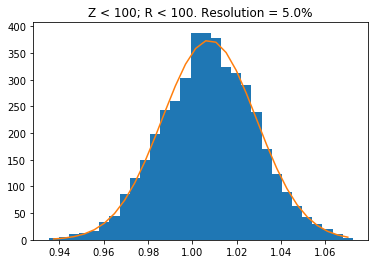

Fit a Gaussian with guess (A0, m0, s0) = (841.0, 1.0072995260024191, 0.06588391167837411)


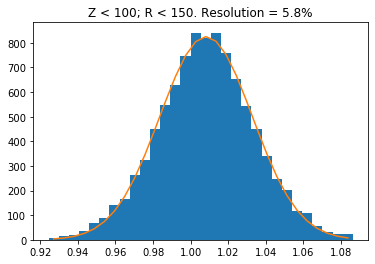

Fit a Gaussian with guess (A0, m0, s0) = (1079.0, 1.0078387285368686, 0.06930767209416844)


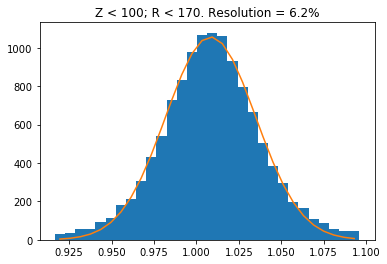

Fit a Gaussian with guess (A0, m0, s0) = (211.0, 1.008469041515344, 0.058694877835850354)


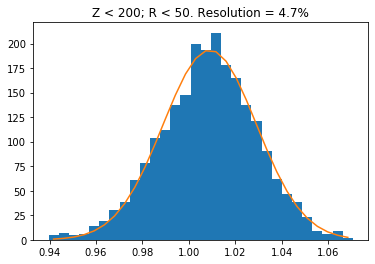

Fit a Gaussian with guess (A0, m0, s0) = (782.0, 1.0072215436639151, 0.054910037065004386)


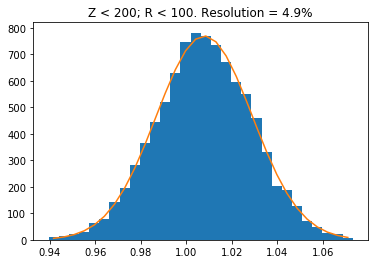

Fit a Gaussian with guess (A0, m0, s0) = (1785.0, 1.0080837282782298, 0.05906284740036731)


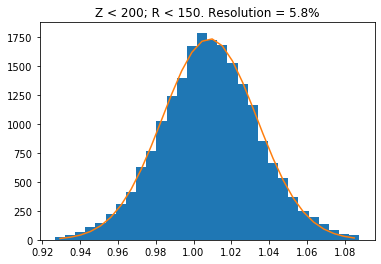

Fit a Gaussian with guess (A0, m0, s0) = (2312.0, 1.0086276645101213, 0.06399359321688734)


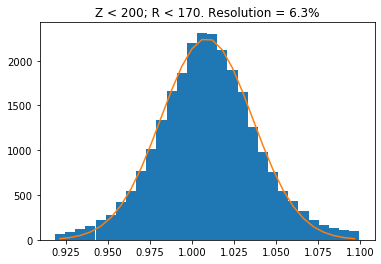

Fit a Gaussian with guess (A0, m0, s0) = (311.0, 1.0093470540487797, 0.05756684327151021)


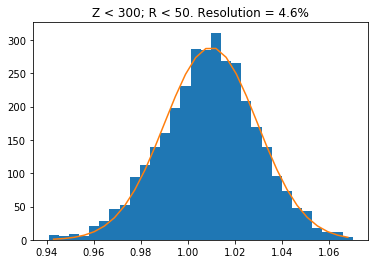

Fit a Gaussian with guess (A0, m0, s0) = (1153.0, 1.0081862457129254, 0.054114297786268646)


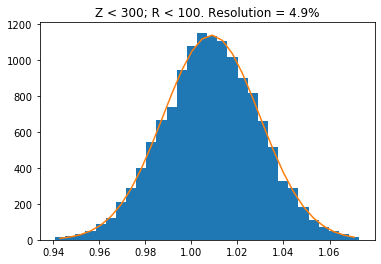

Fit a Gaussian with guess (A0, m0, s0) = (2652.0, 1.0088463839642337, 0.05883137017695918)


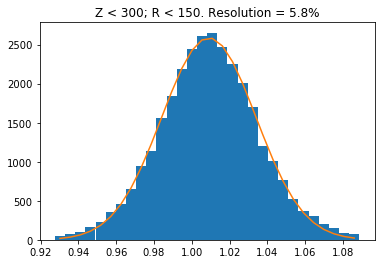

Fit a Gaussian with guess (A0, m0, s0) = (3468.0, 1.0093815062792608, 0.06410064488748522)


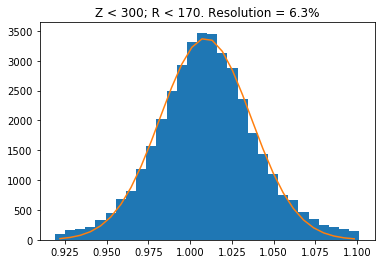

Fit a Gaussian with guess (A0, m0, s0) = (425.0, 1.0095685596225625, 0.05360883427643801)


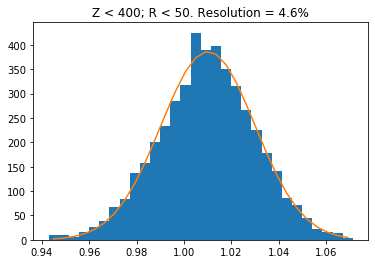

Fit a Gaussian with guess (A0, m0, s0) = (1576.0, 1.0089028528776687, 0.05254833523446173)


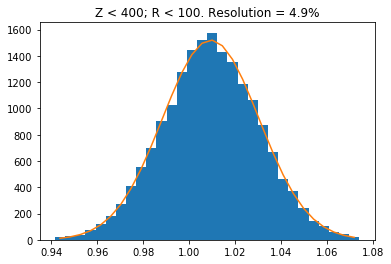

Fit a Gaussian with guess (A0, m0, s0) = (3592.0, 1.0095589340342876, 0.05746938092310482)


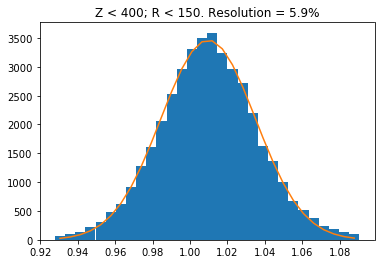

Fit a Gaussian with guess (A0, m0, s0) = (4584.0, 1.0100692501391317, 0.06343687379098557)


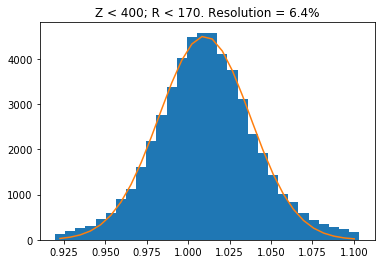

Fit a Gaussian with guess (A0, m0, s0) = (545.0, 1.0099791594888459, 0.05107753843355212)


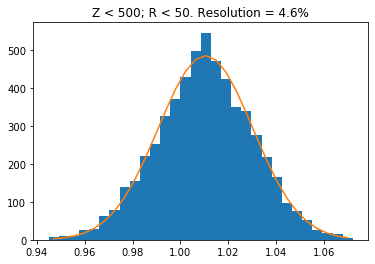

Fit a Gaussian with guess (A0, m0, s0) = (1954.0, 1.0094931379157097, 0.05005103084778285)


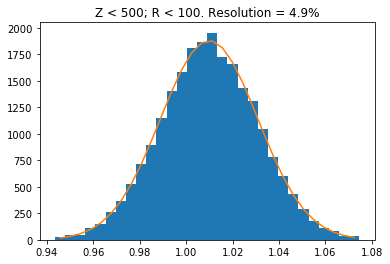

Fit a Gaussian with guess (A0, m0, s0) = (4327.0, 1.0101596884776332, 0.05525197250064228)


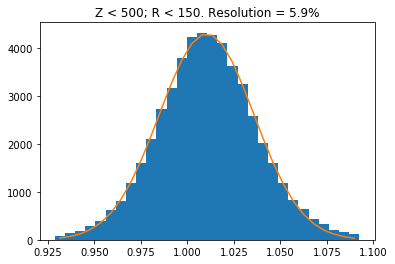

Fit a Gaussian with guess (A0, m0, s0) = (5709.0, 1.0107614261252018, 0.06161138842742077)


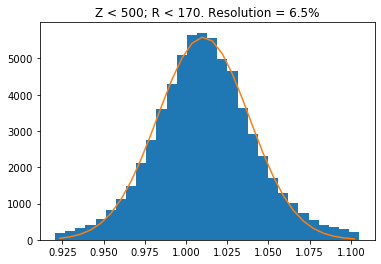

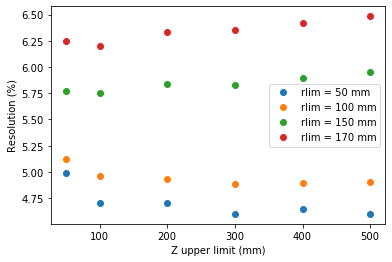

Innermost resolution =  4.99 %
Outermost resolution =  6.48 %


In [58]:
file_7472   = '/Volumes/NEXT_Data/IC_Data/st190819/maps/kr_emap_xy_50_50_r_7472_st190819.h5'

emask = (hiE < 16000) & (hiE > 6000)
nomask = np.ones(len(hiE), dtype='bool')

# def correct_energies(emap, bounds, umask, xvals, yvals, zvals, energies, ltmap = None, show = True, vocal = False):

e0_7472, lt_7472, bounds_7472 = load_maps_from_file(file_7472)
r7472_scaled_energy_json = correct_energies(e0_7472, bounds_7472, emask, hiX, hiY, hiZ, hiE, ltmap = lt_7472, vocal = True)
r7472_res_vs_zr_json = fit_res_vs_zr(r7472_scaled_energy_json, bounds_7472, emask, hiX, hiY, hiZ, show = True)
plot_res_vs_zr(r7472_res_vs_zr_json)

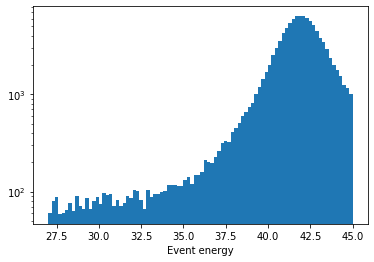

In [59]:
json_bootcor_energies = r7472_scaled_energy_json * 41.5

plt.hist(json_bootcor_energies, range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy')
plt.show()

## Examine new json, with gravity position methods

In [60]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20210113/meshed_output_allfiles_'+runno+'_20210112.json')
histat_json_cgrav = js.load(f)
f.close()

In [61]:
histat_json_cgrav.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'events_localit_X', 'events_localit_Y', 'events_local_X', 'events_local_Y', 'events_global_X', 'events_global_Y', 'ring_events_sipm_aroundevt', 'ring_events_sipm_aroundevt_noctr', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres', 'all_cutoff'])

In [62]:
hiGZ, hiGE = np.array(histat_json_cgrav['all_Zrms']), np.array(histat_json_cgrav['events_energy'])

In [63]:
hiX_glob, hiY_glob   = np.array(histat_json_cgrav['events_global_X']), np.array(histat_json_cgrav['events_global_Y'])
hiX_loc, hiY_loc     = np.array(histat_json_cgrav['events_local_X']), np.array(histat_json_cgrav['events_local_Y'])
hiX_locit, hiY_locit = np.array(histat_json_cgrav['events_localit_X']), np.array(histat_json_cgrav['events_localit_Y'])

In [64]:
file_7472   = '/Volumes/NEXT_Data/IC_Data/st190819/maps/kr_emap_xy_50_50_r_7472_st190819.h5'

emask = (hiGE < 16000) & (hiGE > 6000)
nomask = np.ones(len(hiGE), dtype='bool')

Correcting energies...
0 / 122758
10000 / 122758
Est remaining = 393.7
20000 / 122758
Est remaining = 389.8
30000 / 122758
Est remaining = 363.9
40000 / 122758
Est remaining = 332.9
50000 / 122758
Est remaining = 301.1
60000 / 122758
Est remaining = 259.3
70000 / 122758
Est remaining = 212.4
80000 / 122758
Est remaining = 168.8
90000 / 122758
Est remaining = 128.6
100000 / 122758
Est remaining = 89.3
110000 / 122758
Est remaining = 49.7
120000 / 122758
Est remaining = 10.8


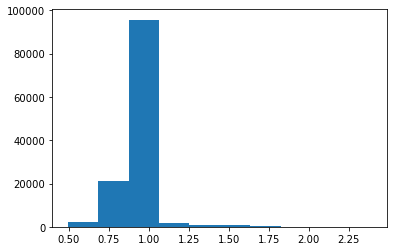

Fit a Gaussian with guess (A0, m0, s0) = (68.0, 1.0015173521229657, 0.09013587040522705)


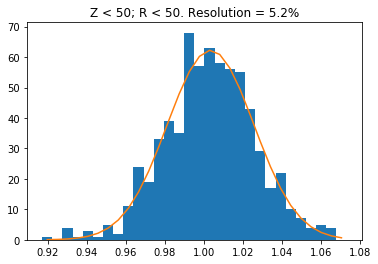

Fit a Gaussian with guess (A0, m0, s0) = (245.0, 0.9850218065407144, 0.08300313869752307)


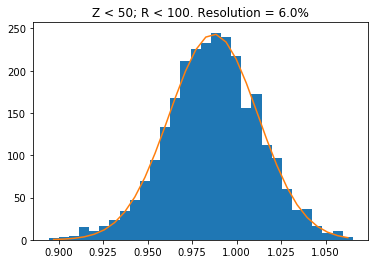

Fit a Gaussian with guess (A0, m0, s0) = (624.0, 0.9629256026076707, 0.09036359682488834)


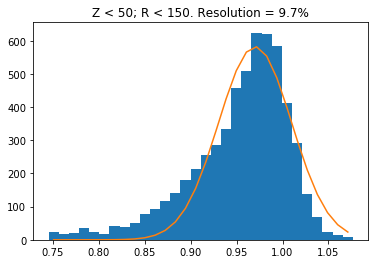

Fit a Gaussian with guess (A0, m0, s0) = (873.0, 0.953094807424776, 0.10318765757572453)


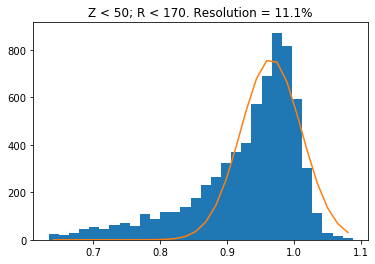

Fit a Gaussian with guess (A0, m0, s0) = (160.0, 1.0032063620606324, 0.0726387848294298)


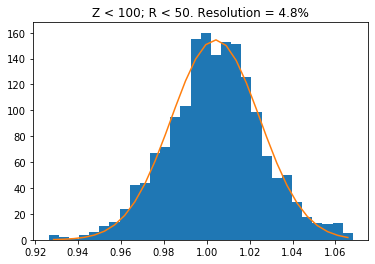

Fit a Gaussian with guess (A0, m0, s0) = (567.0, 0.9873443009163124, 0.06731519491721873)


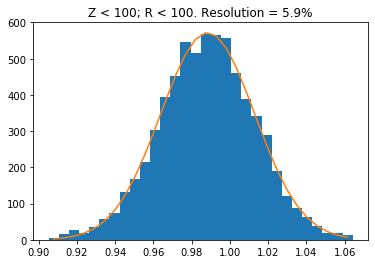

Fit a Gaussian with guess (A0, m0, s0) = (1514.0, 0.964813082856524, 0.07923727875845944)


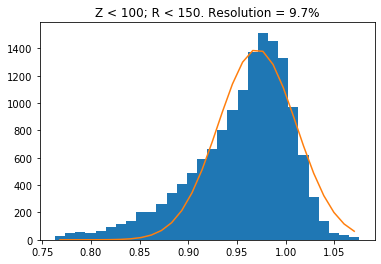

Fit a Gaussian with guess (A0, m0, s0) = (2098.0, 0.953640240137557, 0.09625808301323083)


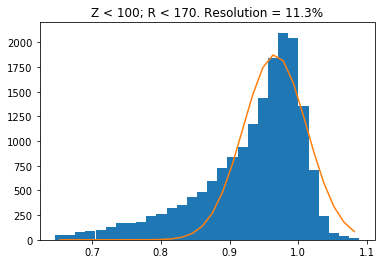

Fit a Gaussian with guess (A0, m0, s0) = (317.0, 1.0035099918092898, 0.06294304374311521)


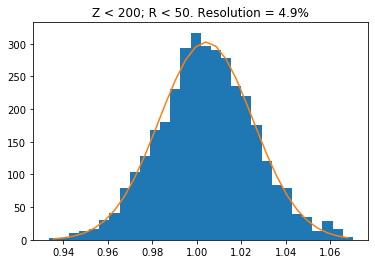

Fit a Gaussian with guess (A0, m0, s0) = (1233.0, 0.9885067889468505, 0.0584831699196998)


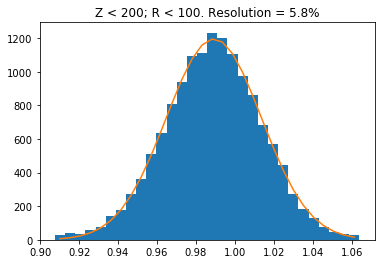

Fit a Gaussian with guess (A0, m0, s0) = (3221.0, 0.9655189332548227, 0.07593929395453715)


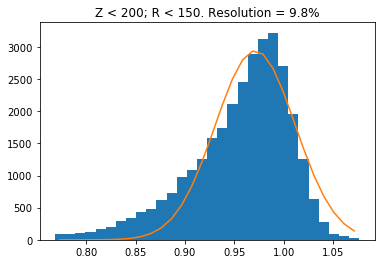

Fit a Gaussian with guess (A0, m0, s0) = (4510.0, 0.9541405754044116, 0.09617599550843733)


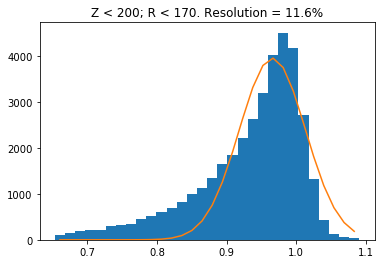

Fit a Gaussian with guess (A0, m0, s0) = (462.0, 1.004518008393069, 0.060781173135228427)


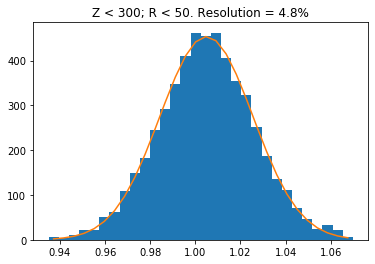

Fit a Gaussian with guess (A0, m0, s0) = (1793.0, 0.9892202153163941, 0.05776353088866648)


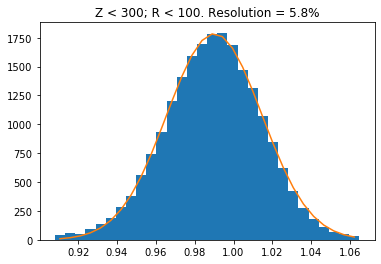

Fit a Gaussian with guess (A0, m0, s0) = (4744.0, 0.9663329924829038, 0.0762138471426456)


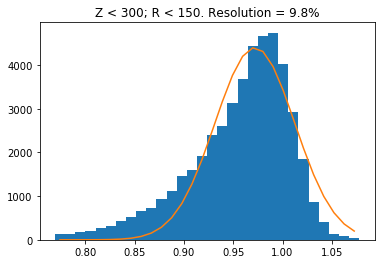

Fit a Gaussian with guess (A0, m0, s0) = (6759.0, 0.9552904242508485, 0.09802069098937774)


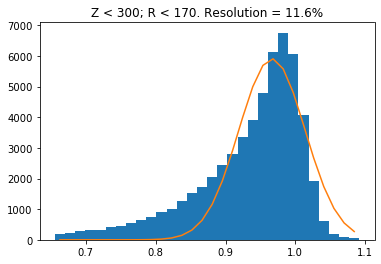

Fit a Gaussian with guess (A0, m0, s0) = (617.0, 1.0051467264627354, 0.057651717558371056)


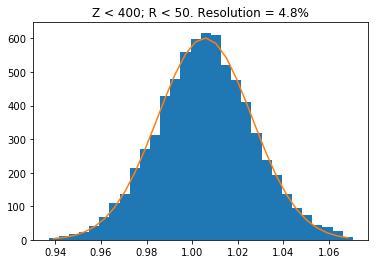

Fit a Gaussian with guess (A0, m0, s0) = (2402.0, 0.9900086055788612, 0.05611396941334906)


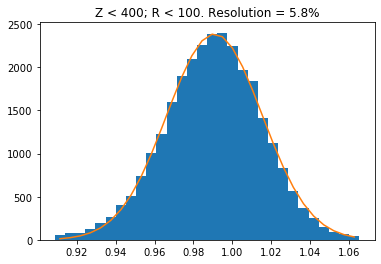

Fit a Gaussian with guess (A0, m0, s0) = (6410.0, 0.9671829804763021, 0.0759401915693209)


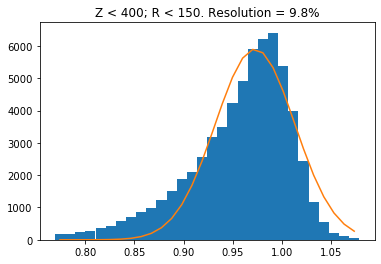

Fit a Gaussian with guess (A0, m0, s0) = (8952.0, 0.9565828483852392, 0.09866427645303909)


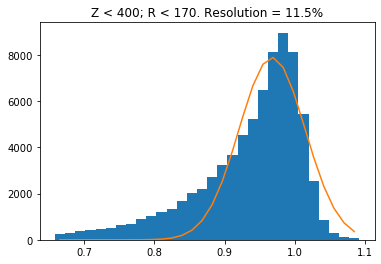

Fit a Gaussian with guess (A0, m0, s0) = (770.0, 1.0056650905937161, 0.055054571240498784)


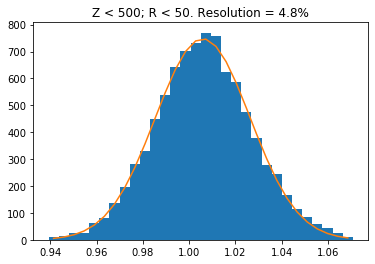

Fit a Gaussian with guess (A0, m0, s0) = (2967.0, 0.9907201879750682, 0.05393588001054149)


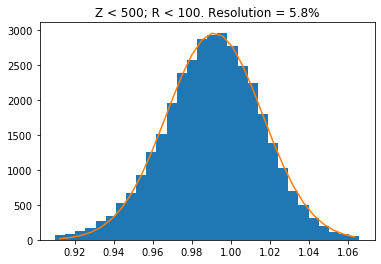

Fit a Gaussian with guess (A0, m0, s0) = (8018.0, 0.9679099654592418, 0.07503203872470822)


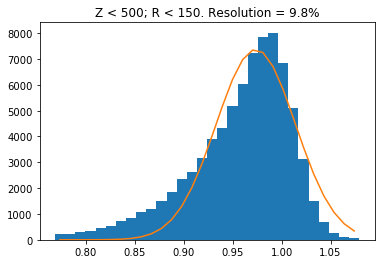

Fit a Gaussian with guess (A0, m0, s0) = (11140.0, 0.9576188212527046, 0.09820473022658446)


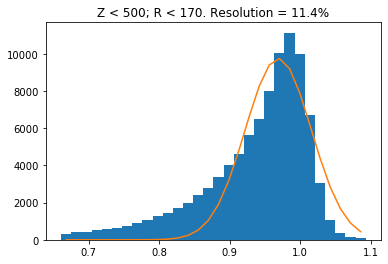

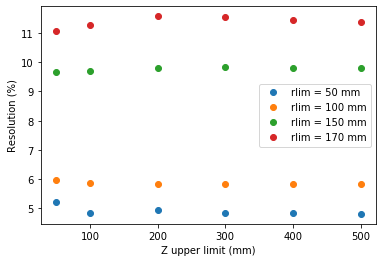

Innermost resolution =  5.22 %
Outermost resolution =  11.4 %


In [65]:
r7472_scaled_energy_json_glob = correct_energies(e0_7472, bounds_7472, emask, hiX_glob, hiY_glob, hiGZ, hiGE, ltmap = lt_7472, vocal = True)
r7472_res_vs_zr_json_glob = fit_res_vs_zr(r7472_scaled_energy_json_glob, bounds_7472, emask, hiX_glob, hiY_glob, hiGZ, show = True)
plot_res_vs_zr(r7472_res_vs_zr_json_glob)

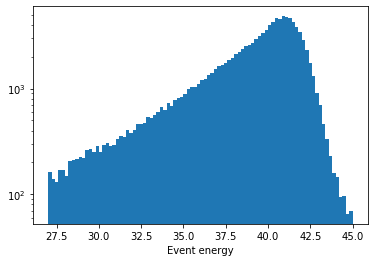

In [66]:
json_bootcor_energies_glob = r7472_scaled_energy_json_glob * 41.5

plt.hist(json_bootcor_energies_glob, range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy')
plt.show()

Correcting energies...
0 / 122275
10000 / 122275
Est remaining = 436.3
20000 / 122275
Est remaining = 427.2
30000 / 122275
Est remaining = 390.6
40000 / 122275
Est remaining = 362.6
50000 / 122275
Est remaining = 324.3
60000 / 122275
Est remaining = 279.6
70000 / 122275
Est remaining = 235.8
80000 / 122275
Est remaining = 191.0
90000 / 122275
Est remaining = 145.1
100000 / 122275
Est remaining = 101.4
110000 / 122275
Est remaining = 56.4
120000 / 122275
Est remaining = 10.5


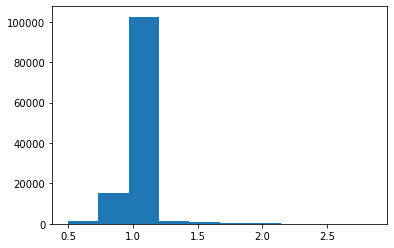

Fit a Gaussian with guess (A0, m0, s0) = (44.0, 1.005281478522123, 0.08660974158151191)


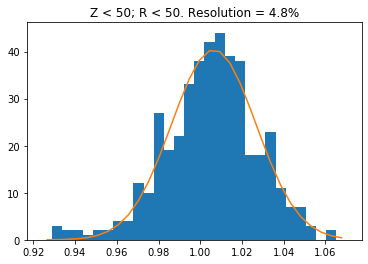

Fit a Gaussian with guess (A0, m0, s0) = (174.0, 1.005236243675847, 0.0812825048911661)


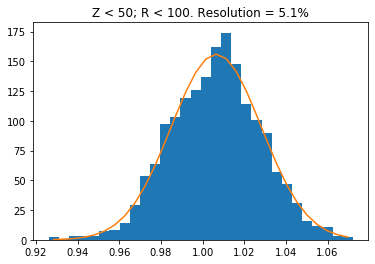

Fit a Gaussian with guess (A0, m0, s0) = (368.0, 1.0057216730202985, 0.0816576813664895)


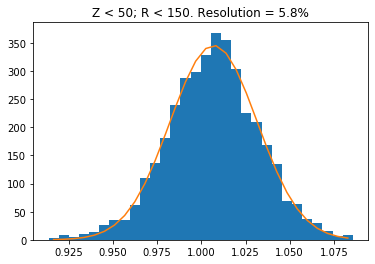

Fit a Gaussian with guess (A0, m0, s0) = (470.0, 1.005855504072965, 0.08212672931581944)


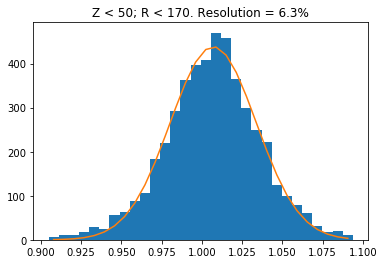

Fit a Gaussian with guess (A0, m0, s0) = (113.0, 1.0069064009811926, 0.06962707039022481)


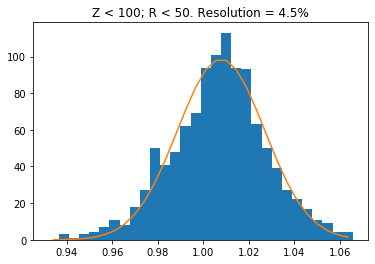

Fit a Gaussian with guess (A0, m0, s0) = (401.0, 1.006447421578464, 0.06483160768564579)


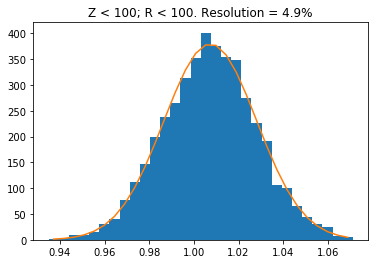

Fit a Gaussian with guess (A0, m0, s0) = (860.0, 1.007165164372882, 0.06627799091627413)


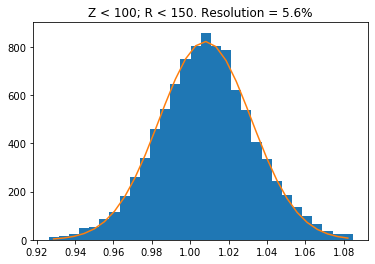

Fit a Gaussian with guess (A0, m0, s0) = (1114.0, 1.0075175411110466, 0.06868133344683679)


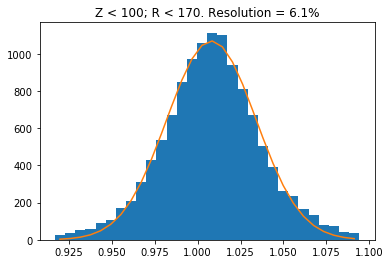

Fit a Gaussian with guess (A0, m0, s0) = (214.0, 1.0072971479215447, 0.05965632036665267)


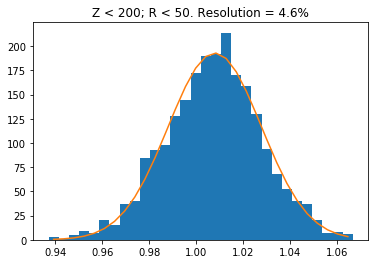

Fit a Gaussian with guess (A0, m0, s0) = (783.0, 1.0070909308317617, 0.05568042968282598)


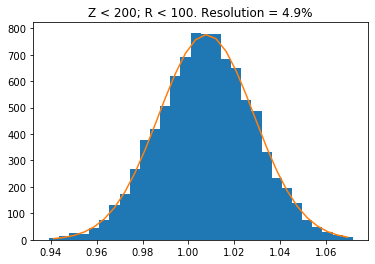

Fit a Gaussian with guess (A0, m0, s0) = (1812.0, 1.0079259810134291, 0.05955261133214297)


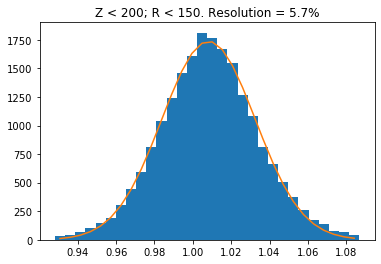

Fit a Gaussian with guess (A0, m0, s0) = (2372.0, 1.0082630192002418, 0.0637071041634123)


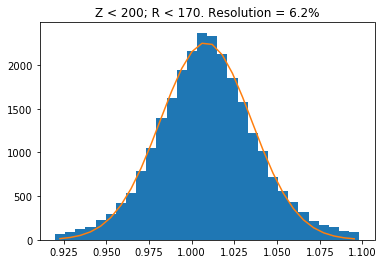

Fit a Gaussian with guess (A0, m0, s0) = (302.0, 1.0083623303919744, 0.0592316471458427)


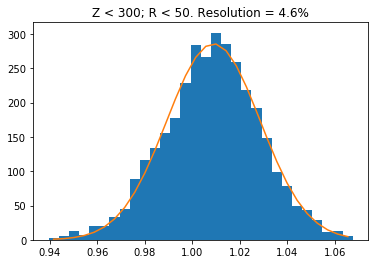

Fit a Gaussian with guess (A0, m0, s0) = (1148.0, 1.0080795365161173, 0.05465500153884646)


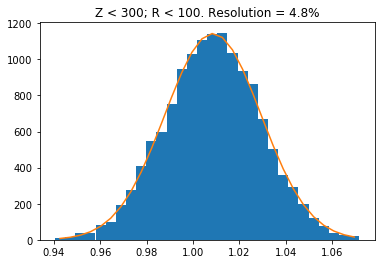

Fit a Gaussian with guess (A0, m0, s0) = (2637.0, 1.0086368746978243, 0.0590915258651942)


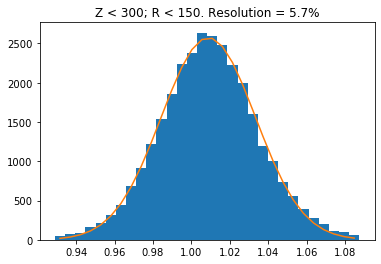

Fit a Gaussian with guess (A0, m0, s0) = (3459.0, 1.0090407499969933, 0.06373351655835287)


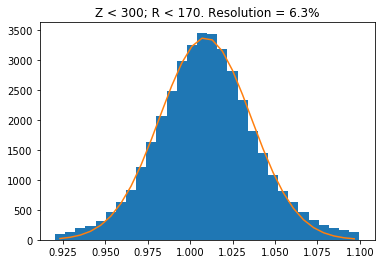

Fit a Gaussian with guess (A0, m0, s0) = (404.0, 1.008717448932127, 0.05496038040596294)


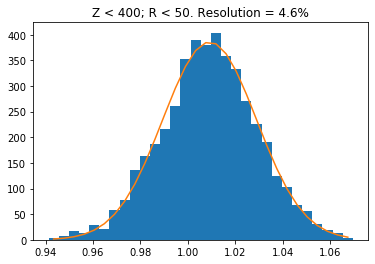

Fit a Gaussian with guess (A0, m0, s0) = (1528.0, 1.0089095996236308, 0.05293379355330486)


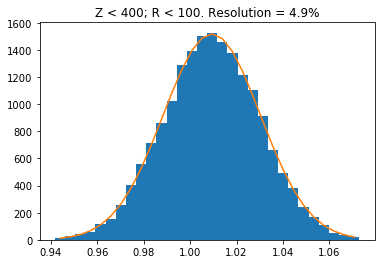

Fit a Gaussian with guess (A0, m0, s0) = (3517.0, 1.0093695464580184, 0.05752972778338026)


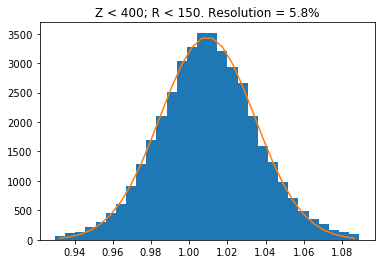

Fit a Gaussian with guess (A0, m0, s0) = (4634.0, 1.009780090098998, 0.06319991941254645)


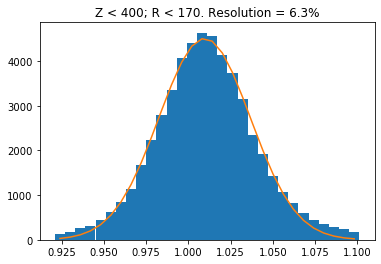

Fit a Gaussian with guess (A0, m0, s0) = (504.0, 1.00898218516881, 0.05243707619073372)


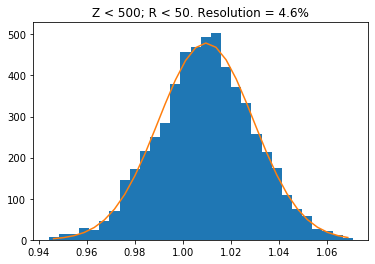

Fit a Gaussian with guess (A0, m0, s0) = (1970.0, 1.0094374431147546, 0.05039837650211361)


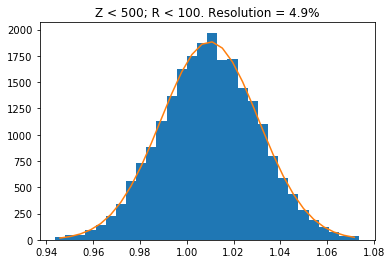

Fit a Gaussian with guess (A0, m0, s0) = (4365.0, 1.0100495838743508, 0.05527791598150986)


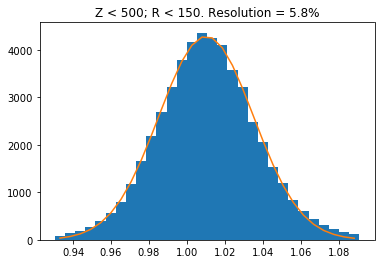

Fit a Gaussian with guess (A0, m0, s0) = (5724.0, 1.0105314793865765, 0.061273925841600366)


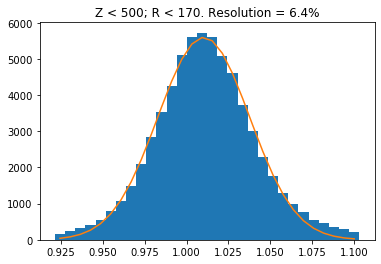

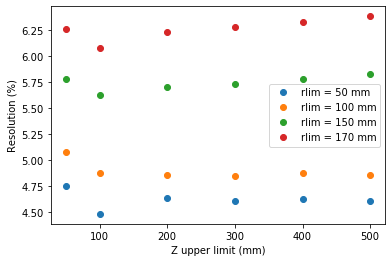

Innermost resolution =  4.75 %
Outermost resolution =  6.38 %


In [67]:
r7472_scaled_energy_json_loc = correct_energies(e0_7472, bounds_7472, emask, hiX_loc, hiY_loc, hiGZ, hiGE, ltmap = lt_7472, vocal = True)
r7472_res_vs_zr_json_loc = fit_res_vs_zr(r7472_scaled_energy_json_loc, bounds_7472, emask, hiX_loc, hiY_loc, hiGZ, show = True)
plot_res_vs_zr(r7472_res_vs_zr_json_loc)

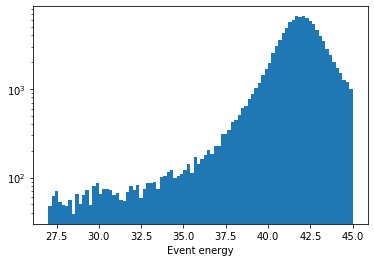

In [68]:
json_bootcor_energies_loc = r7472_scaled_energy_json_loc * 41.5

plt.hist(json_bootcor_energies_loc, range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy')
plt.show()

Correcting energies...
0 / 122254
10000 / 122254
Est remaining = 490.5
20000 / 122254
Est remaining = 418.4
30000 / 122254
Est remaining = 358.6
40000 / 122254
Est remaining = 354.7
50000 / 122254
Est remaining = 313.1
60000 / 122254
Est remaining = 271.1
70000 / 122254
Est remaining = 227.7
80000 / 122254
Est remaining = 181.1
90000 / 122254
Est remaining = 138.7
100000 / 122254
Est remaining = 94.5
110000 / 122254
Est remaining = 51.1
120000 / 122254
Est remaining = 9.3


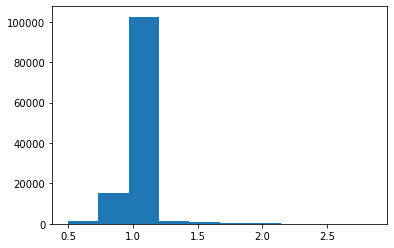

Fit a Gaussian with guess (A0, m0, s0) = (44.0, 1.0050993416279619, 0.08637875360102572)


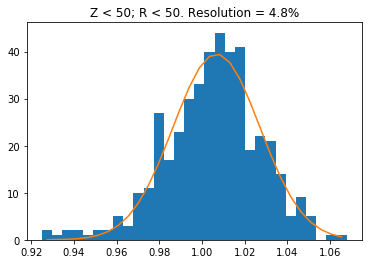

Fit a Gaussian with guess (A0, m0, s0) = (175.0, 1.0051858128310533, 0.08077206370877335)


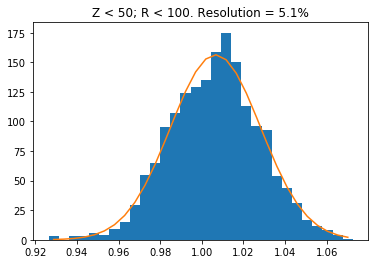

Fit a Gaussian with guess (A0, m0, s0) = (366.0, 1.0056112152898251, 0.08188251948458679)


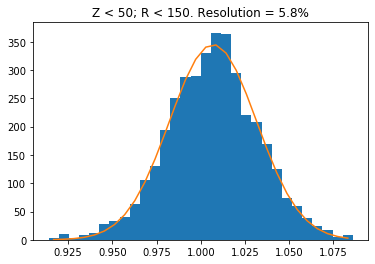

Fit a Gaussian with guess (A0, m0, s0) = (466.0, 1.0058414938321367, 0.08214654016739313)


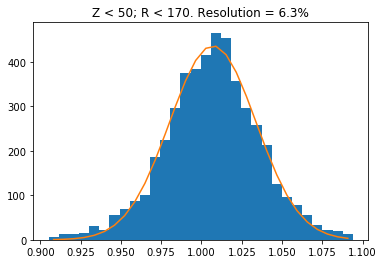

Fit a Gaussian with guess (A0, m0, s0) = (106.0, 1.0067104150387056, 0.06955909741725942)


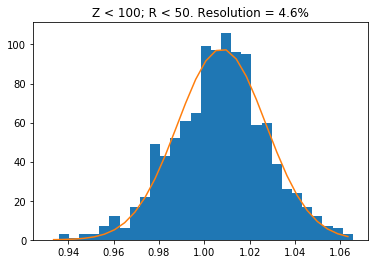

Fit a Gaussian with guess (A0, m0, s0) = (395.0, 1.0063684198916918, 0.06459121119304768)


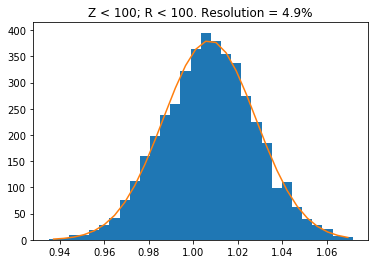

Fit a Gaussian with guess (A0, m0, s0) = (847.0, 1.0070704372328827, 0.06637629623282859)


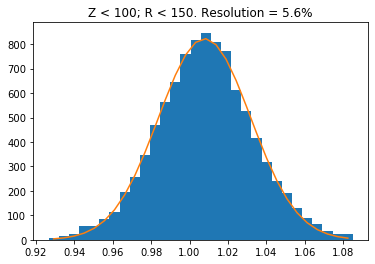

Fit a Gaussian with guess (A0, m0, s0) = (1104.0, 1.0074298794490693, 0.06868186699472772)


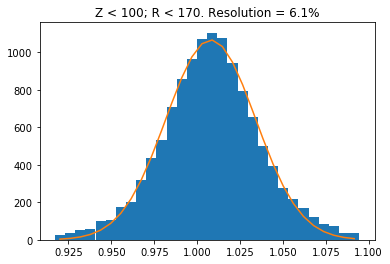

Fit a Gaussian with guess (A0, m0, s0) = (201.0, 1.006989082252451, 0.059608668226232876)


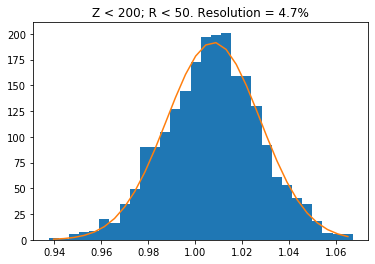

Fit a Gaussian with guess (A0, m0, s0) = (798.0, 1.007036048213846, 0.05551958733443986)


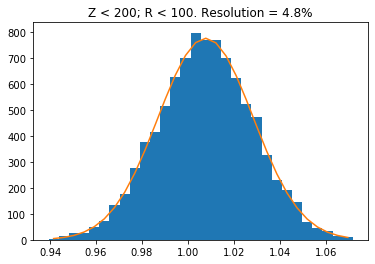

Fit a Gaussian with guess (A0, m0, s0) = (1790.0, 1.007912352322092, 0.059575308415452506)


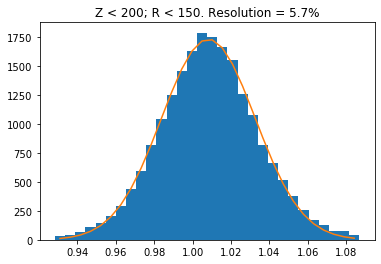

Fit a Gaussian with guess (A0, m0, s0) = (2354.0, 1.0082636169064645, 0.06358610785008577)


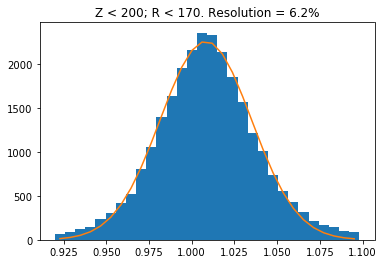

Fit a Gaussian with guess (A0, m0, s0) = (294.0, 1.0081865358233386, 0.059199895633653694)


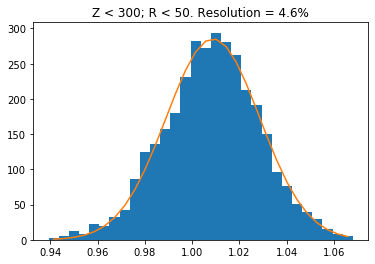

Fit a Gaussian with guess (A0, m0, s0) = (1137.0, 1.0080482031001903, 0.05447970956198711)


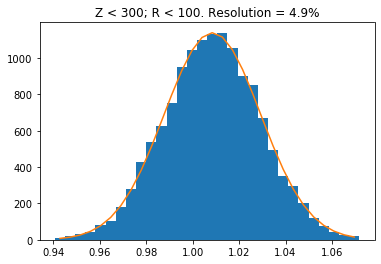

Fit a Gaussian with guess (A0, m0, s0) = (2615.0, 1.0086632853199622, 0.05911007840127986)


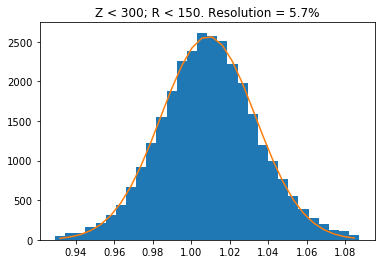

Fit a Gaussian with guess (A0, m0, s0) = (3445.0, 1.0090472109251216, 0.06364835098576088)


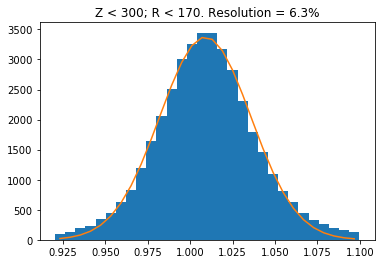

Fit a Gaussian with guess (A0, m0, s0) = (406.0, 1.00866807443852, 0.05492988057077692)


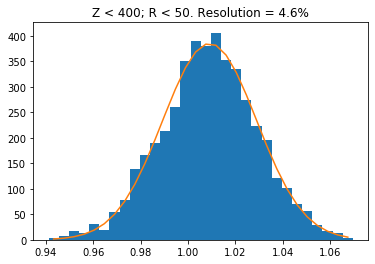

Fit a Gaussian with guess (A0, m0, s0) = (1531.0, 1.008875324989681, 0.052794708443030754)


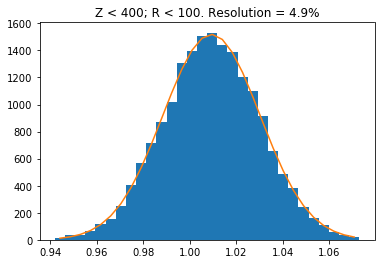

Fit a Gaussian with guess (A0, m0, s0) = (3519.0, 1.0093953818477823, 0.05754430126769372)


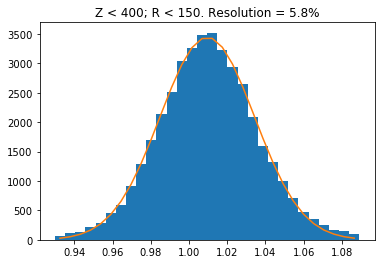

Fit a Gaussian with guess (A0, m0, s0) = (4622.0, 1.0097862872887542, 0.063042571779)


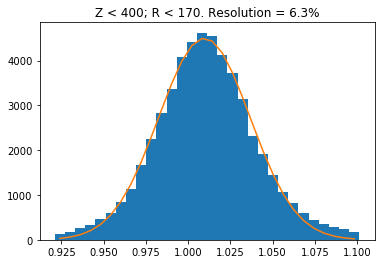

Fit a Gaussian with guess (A0, m0, s0) = (511.0, 1.0089589040260012, 0.052425848137148685)


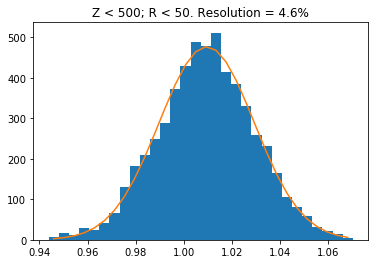

Fit a Gaussian with guess (A0, m0, s0) = (1969.0, 1.0094239353138157, 0.050275633289547574)


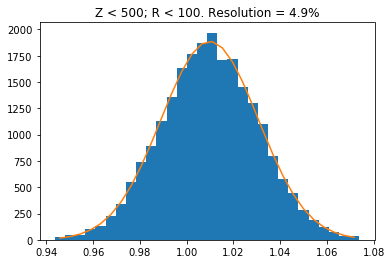

Fit a Gaussian with guess (A0, m0, s0) = (4359.0, 1.0100938333714318, 0.05529338628290801)


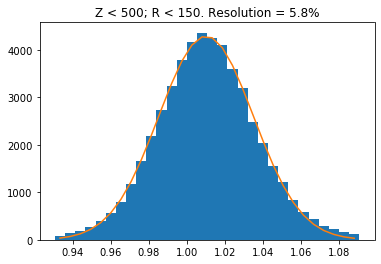

Fit a Gaussian with guess (A0, m0, s0) = (5729.0, 1.010528676950213, 0.0611354286666226)


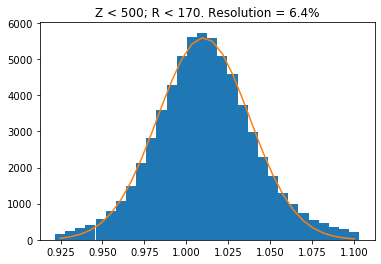

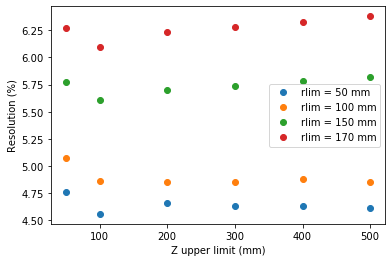

Innermost resolution =  4.76 %
Outermost resolution =  6.38 %


In [69]:
r7472_scaled_energy_json_locit = correct_energies(e0_7472, bounds_7472, emask, hiX_locit, hiY_locit, hiGZ, hiGE, ltmap = lt_7472, vocal = True)
r7472_res_vs_zr_json_locit = fit_res_vs_zr(r7472_scaled_energy_json_locit, bounds_7472, emask, hiX_locit, hiY_locit, hiGZ, show = True)
plot_res_vs_zr(r7472_res_vs_zr_json_locit)

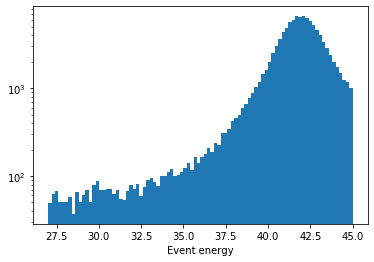

In [70]:
json_bootcor_energies_locit = r7472_scaled_energy_json_locit * 41.5

plt.hist(json_bootcor_energies_locit, range = (27, 45), bins = 90)
plt.yscale('log')
plt.xlabel('Event energy')
plt.show()

In [71]:
printtime('Finished.')

Finished. Current time = 4299.9


In [72]:
from random import random

In [73]:
random()

0.7890234415680906

In [74]:
histat_json.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [75]:
from invisible_cities.reco.corrections     import read_maps
from krcal.map_builder.map_builder_functions  import e0_xy_correction

bootstrap_map      = read_maps(file_7472)
geom_corr = e0_xy_correction(bootstrap_map)

### Check resolution in json

Fit a Gaussian with guess (A0, m0, s0) = (52.0, 12674.086399681411, 908.5853477737453)


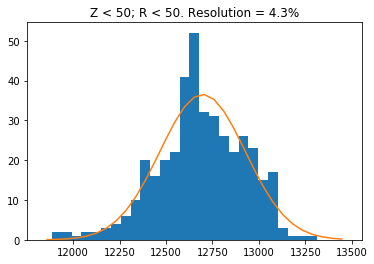

Fit a Gaussian with guess (A0, m0, s0) = (143.0, 12689.356060404101, 857.5017229448354)


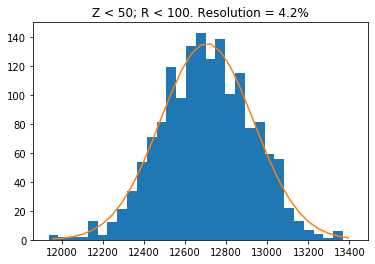

Fit a Gaussian with guess (A0, m0, s0) = (321.0, 12695.455903876482, 855.691939748225)


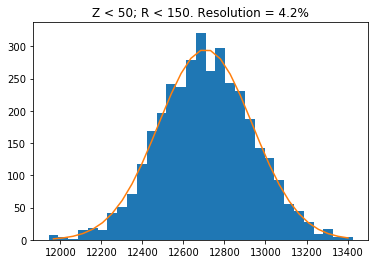

Fit a Gaussian with guess (A0, m0, s0) = (392.0, 12702.432318872205, 858.7479063769367)


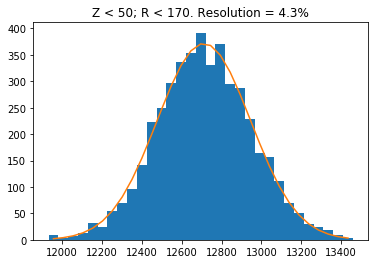

Fit a Gaussian with guess (A0, m0, s0) = (115.0, 12657.896307136703, 756.1456897420172)


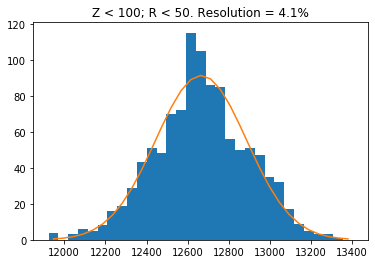

Fit a Gaussian with guess (A0, m0, s0) = (363.0, 12658.987517053283, 705.4409960732119)


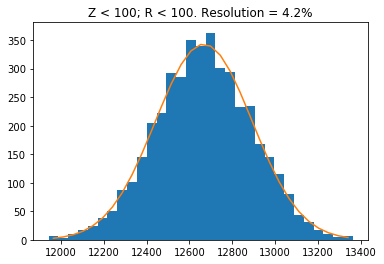

Fit a Gaussian with guess (A0, m0, s0) = (765.0, 12665.607459613517, 718.0519717935357)


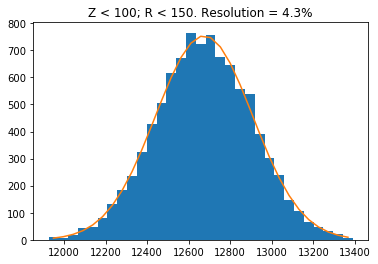

Fit a Gaussian with guess (A0, m0, s0) = (988.0, 12675.061587221826, 740.692846874548)


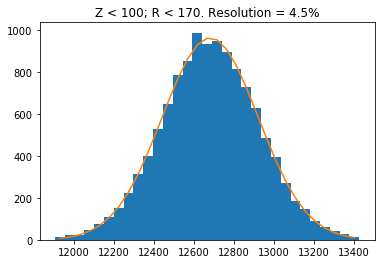

Fit a Gaussian with guess (A0, m0, s0) = (197.0, 12596.014579750234, 668.0307320204467)


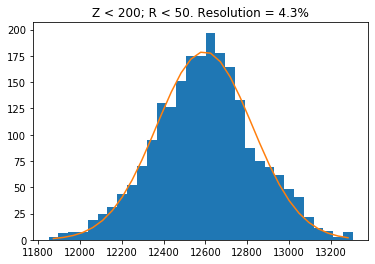

Fit a Gaussian with guess (A0, m0, s0) = (741.0, 12586.166591639667, 622.202487917992)


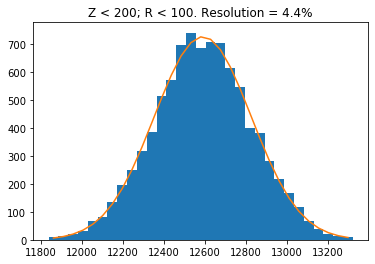

Fit a Gaussian with guess (A0, m0, s0) = (1669.0, 12591.428043306949, 658.8485594539258)


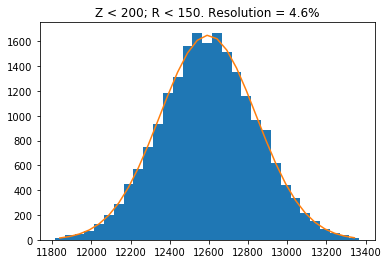

Fit a Gaussian with guess (A0, m0, s0) = (2123.0, 12598.307981238886, 706.0092875585448)


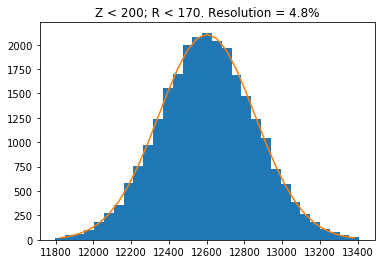

Fit a Gaussian with guess (A0, m0, s0) = (274.0, 12523.821480859913, 675.6197131969897)


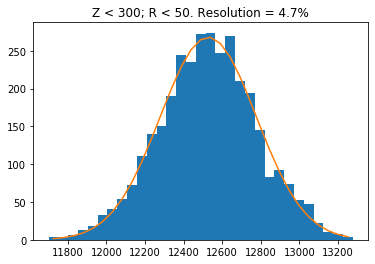

Fit a Gaussian with guess (A0, m0, s0) = (1143.0, 12515.704571210976, 631.3943942726294)


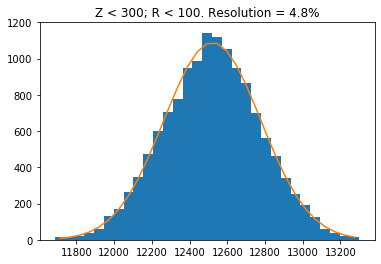

Fit a Gaussian with guess (A0, m0, s0) = (2492.0, 12521.23510646237, 671.4692684994111)


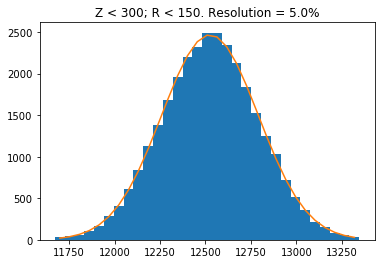

Fit a Gaussian with guess (A0, m0, s0) = (3200.0, 12527.975000215898, 720.1282955484594)


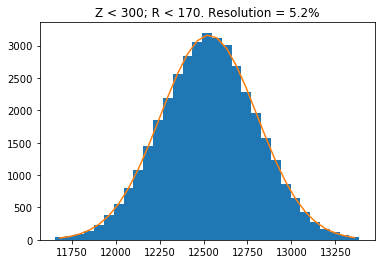

Fit a Gaussian with guess (A0, m0, s0) = (362.0, 12443.543820060298, 641.4266518335606)


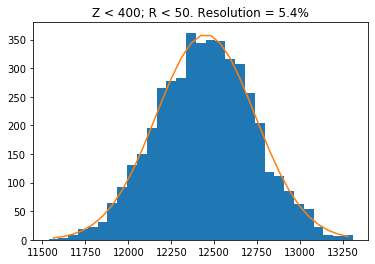

Fit a Gaussian with guess (A0, m0, s0) = (1428.0, 12439.744280767369, 628.4085167822483)


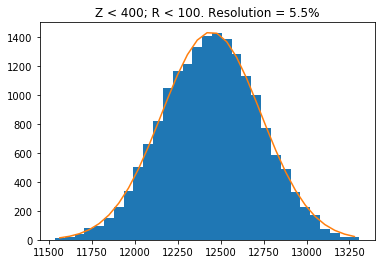

Fit a Gaussian with guess (A0, m0, s0) = (3253.0, 12446.266497527273, 666.1312321752597)


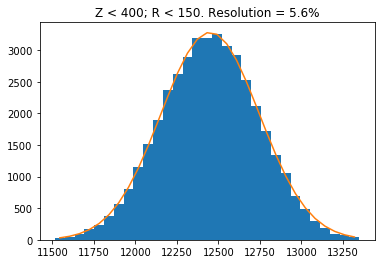

Fit a Gaussian with guess (A0, m0, s0) = (4150.0, 12453.965926567613, 720.4672066069656)


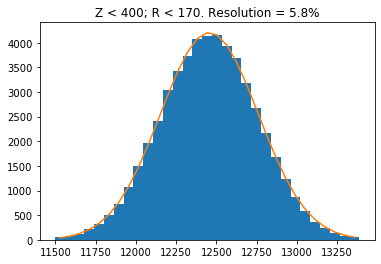

Fit a Gaussian with guess (A0, m0, s0) = (457.0, 12368.5780869673, 623.5213362221754)


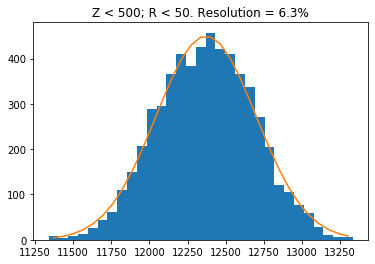

Fit a Gaussian with guess (A0, m0, s0) = (1729.0, 12366.757163753797, 611.1031065001478)


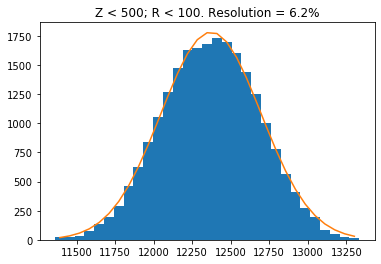

Fit a Gaussian with guess (A0, m0, s0) = (3987.0, 12373.11419887409, 649.7981043503509)


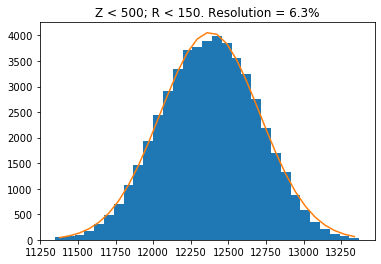

Fit a Gaussian with guess (A0, m0, s0) = (5095.0, 12380.740557002551, 706.65492106291)


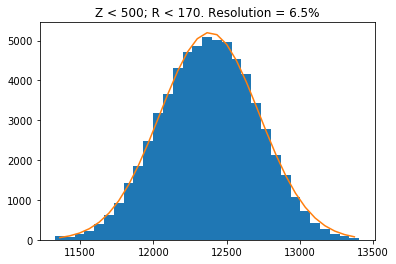

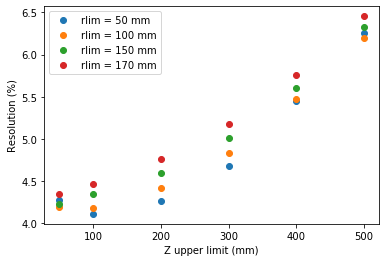

Innermost resolution =  4.27 %
Outermost resolution =  6.45 %


In [76]:
ezmask = (hiE < 16000) & (hiE > 6000) & (hiZ > 10)

corr = geom_corr(hiX[ezmask], hiY[ezmask])
Ebootcorrs = corr * hiE[ezmask]

boot_res_vs_zr = fit_res_vs_zr_matched(Ebootcorrs, bounds_7472, hiX[ezmask], hiY[ezmask], hiZ[ezmask], show = True)
plot_res_vs_zr(boot_res_vs_zr)

### Check resolution in kdst (7479)

Fit a Gaussian with guess (A0, m0, s0) = (53.0, 12584.435172814246, 1119.401784067518)


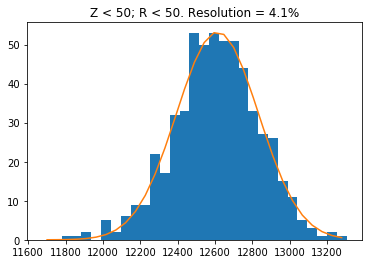

Fit a Gaussian with guess (A0, m0, s0) = (224.0, 12594.049812697656, 1112.4556276658425)


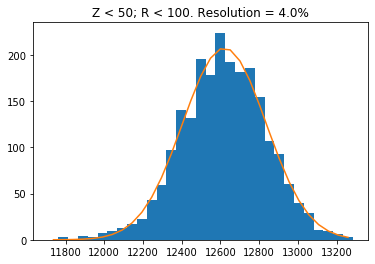

Fit a Gaussian with guess (A0, m0, s0) = (454.0, 12594.965738086436, 1101.3770206971317)


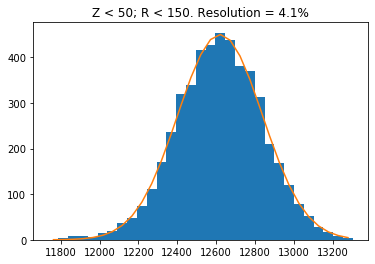

Fit a Gaussian with guess (A0, m0, s0) = (593.0, 12596.392350431179, 1117.4144420451146)


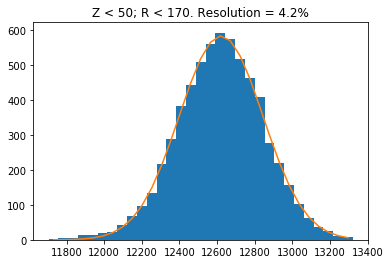

Fit a Gaussian with guess (A0, m0, s0) = (123.0, 12544.741966577569, 1116.4456533991665)


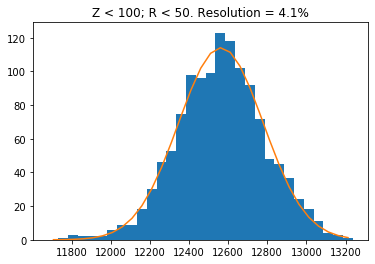

Fit a Gaussian with guess (A0, m0, s0) = (459.0, 12545.57833466059, 1081.2216499452836)


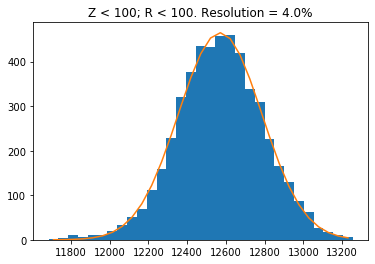

Fit a Gaussian with guess (A0, m0, s0) = (1045.0, 12548.611883031634, 1114.1953811835328)


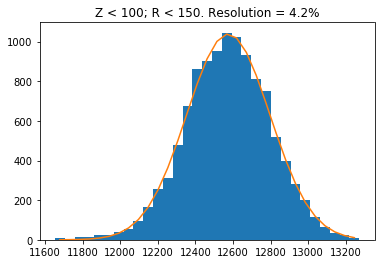

Fit a Gaussian with guess (A0, m0, s0) = (1354.0, 12548.924691324448, 1150.1351698378614)


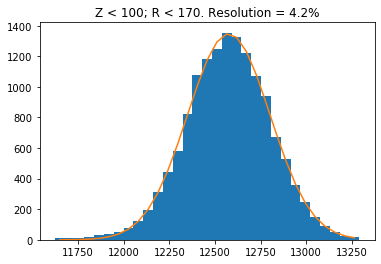

Fit a Gaussian with guess (A0, m0, s0) = (239.0, 12460.413143219468, 1145.677344680234)


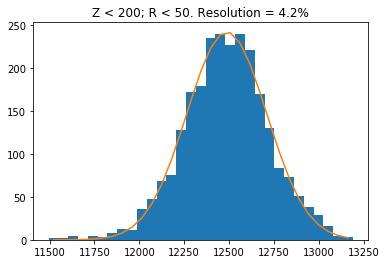

Fit a Gaussian with guess (A0, m0, s0) = (1005.0, 12462.429430912181, 1110.804055478165)


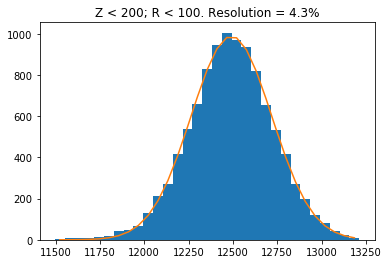

Fit a Gaussian with guess (A0, m0, s0) = (2223.0, 12460.318750387672, 1152.9579233979175)


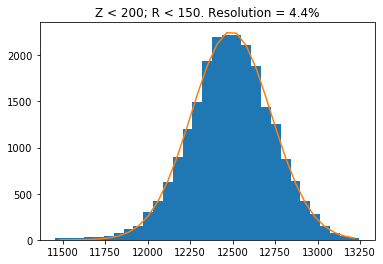

Fit a Gaussian with guess (A0, m0, s0) = (2943.0, 12459.624906530313, 1195.2132246745741)


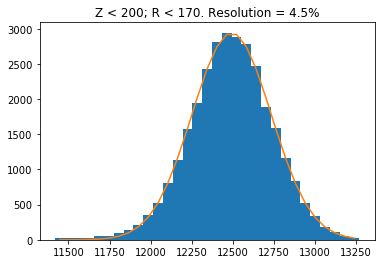

Fit a Gaussian with guess (A0, m0, s0) = (373.0, 12385.017436384187, 1118.54626742977)


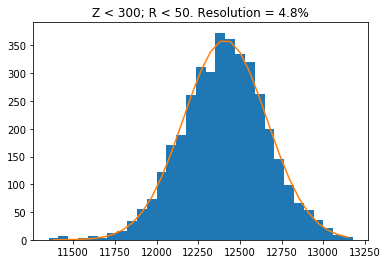

Fit a Gaussian with guess (A0, m0, s0) = (1473.0, 12382.520939215861, 1094.2015367973956)


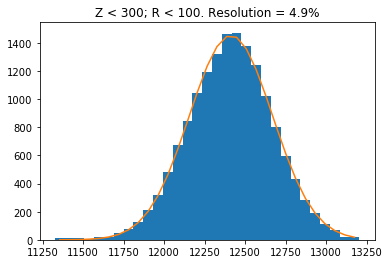

Fit a Gaussian with guess (A0, m0, s0) = (3445.0, 12379.278478918435, 1141.4158000230536)


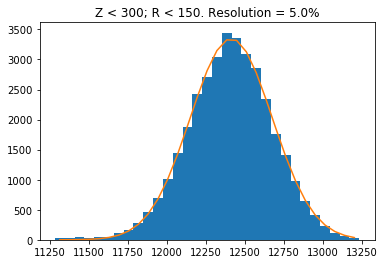

Fit a Gaussian with guess (A0, m0, s0) = (4464.0, 12378.060541318397, 1188.0707838598803)


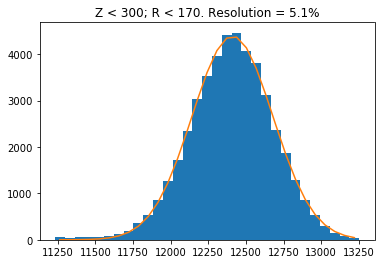

Fit a Gaussian with guess (A0, m0, s0) = (484.0, 12293.723393057666, 1064.1853533028507)


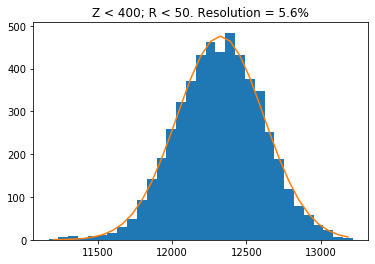

Fit a Gaussian with guess (A0, m0, s0) = (1872.0, 12296.455430505814, 1045.941042606978)


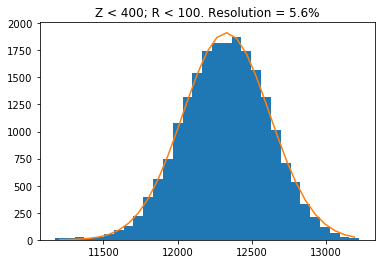

Fit a Gaussian with guess (A0, m0, s0) = (4383.0, 12294.496086915988, 1096.2429491481591)


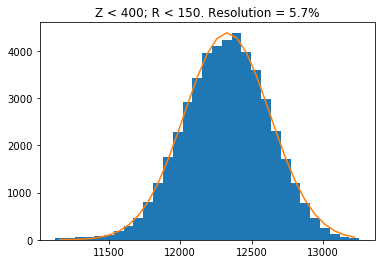

Fit a Gaussian with guess (A0, m0, s0) = (5695.0, 12292.252698398312, 1144.6177005505917)


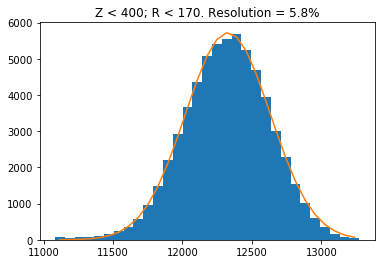

Fit a Gaussian with guess (A0, m0, s0) = (579.0, 12206.198764016252, 1011.2537571579386)


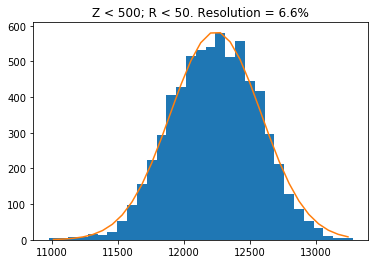

Fit a Gaussian with guess (A0, m0, s0) = (2268.0, 12210.36781095167, 989.8461230122916)


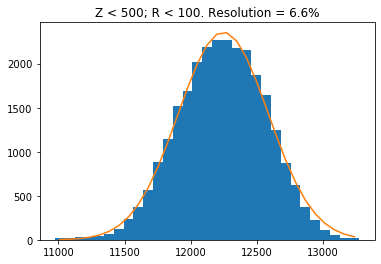

Fit a Gaussian with guess (A0, m0, s0) = (5192.0, 12207.438881565464, 1038.250087252791)


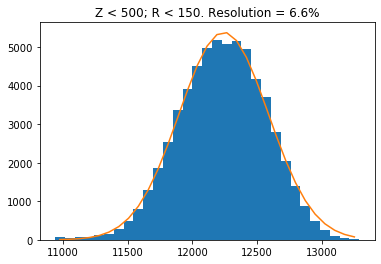

Fit a Gaussian with guess (A0, m0, s0) = (6784.0, 12205.380758537947, 1085.1131792986773)


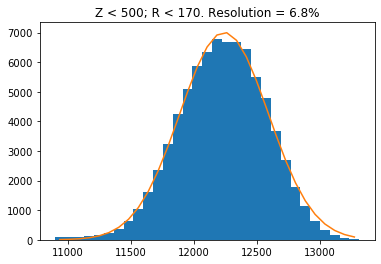

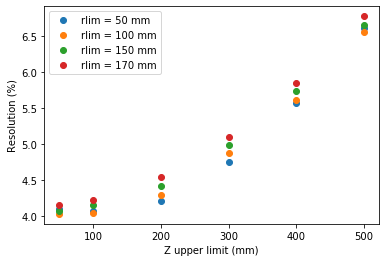

Innermost resolution =  4.11 %
Outermost resolution =  6.77 %


In [77]:
ezmask = (kdstE < 16000) & (kdstE > 6000) & (Zrms > 10)

corr_kdst79 = geom_corr(kdstX[ezmask], kdstY[ezmask])
Ebootcorrs_kdst79 = corr_kdst79 * kdstE[ezmask]

boot_res_vs_zr_kdst79 = fit_res_vs_zr_matched(Ebootcorrs_kdst79, bounds_7472, kdstX[ezmask], kdstY[ezmask], Zrms[ezmask], show = True)
plot_res_vs_zr(boot_res_vs_zr_kdst79)

### Check resolution in kdst (7472)

In [78]:
nkdst_72 = 1000 #9780
#_trigger1_v1.1.0_20190801_krbg.h5 
kdst_filenames_72 = [ '/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_'+ndigit(i, 4)+'_7472_trigger1_v1.1.0_20190801_krbg.h5' for i in range(nkdst_72) ]

In [79]:
all_kdsts_72 = None

printtime()
tstart = time()
tcurrent = tstart
for kfile in kdst_filenames_72:
    if time() - tcurrent > 30:
        tcurrent = time()
        print(kfile, '...')
    xkdst = (pd.HDFStore(kfile, 'r')['DST/Events']).drop(columns = ['S1w', 'S1h', 's1_peak', 's2_peak', 'S1e', 'S1t', 'S2w', 'S2h', 'S2q', 'S2t', 'Nsipm', 'R', 'Phi'])
    if all_kdsts_72 is None:
        all_kdsts_72 = xkdst
    else:
        #print(all_kdsts)
        all_kdsts_72 = all_kdsts_72.append(xkdst)
    #print(kdst.keys())
print('Time for', nkdst_72, '=', round(time() - tstart, 1))

 Current time = 4317.3
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0024_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0285_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0462_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0620_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0758_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0877_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
/Volumes/NEXT_data/IC_Data/kdst/7472/kdst_0985_7472_trigger1_v1.1.0_20190801_krbg.h5 ...
Time for 1000 = 254.5


In [91]:
kdstX_72 = np.array(all_kdsts_72.X)
kdstY_72 = np.array(all_kdsts_72.Y)
Zrms_72 = exp_dt(np.array(all_kdsts_72.Zrms))
ZS1_72 = np.array(all_kdsts_72.Z)
kdstE_72 = np.array(all_kdsts_72.S2e)

Fit a Gaussian with guess (A0, m0, s0) = (303.0, 12581.717350660781, 1163.7872353381986)


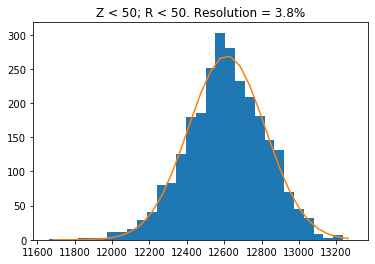

Fit a Gaussian with guess (A0, m0, s0) = (1121.0, 12581.956080337177, 1200.2460063165079)


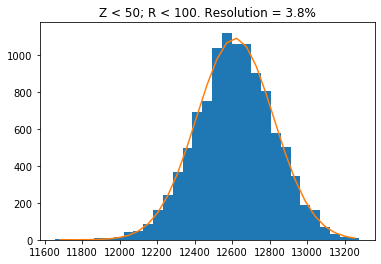

Fit a Gaussian with guess (A0, m0, s0) = (2456.0, 12580.989472504334, 1223.0385409077278)


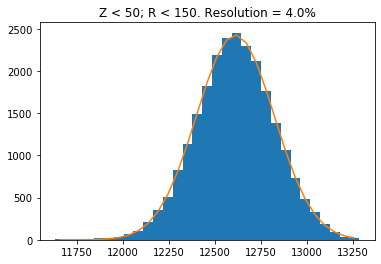

Fit a Gaussian with guess (A0, m0, s0) = (3136.0, 12579.951104107184, 1252.1251485739572)


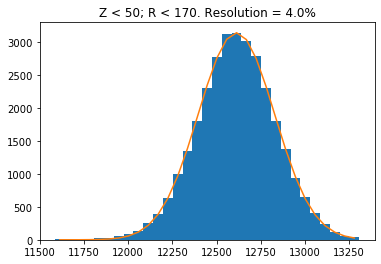

Fit a Gaussian with guess (A0, m0, s0) = (688.0, 12529.624269627835, 1180.6489551705251)


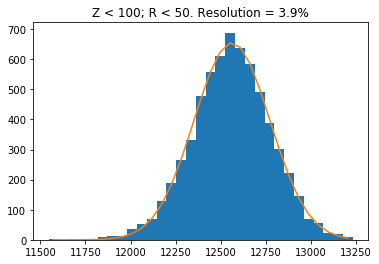

Fit a Gaussian with guess (A0, m0, s0) = (2607.0, 12537.508367602564, 1194.1066797765218)


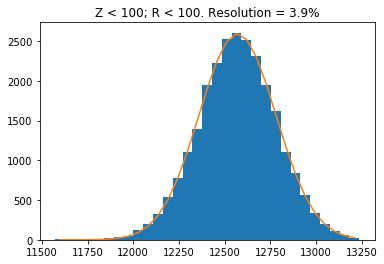

Fit a Gaussian with guess (A0, m0, s0) = (5941.0, 12537.751665482885, 1209.8498277189315)


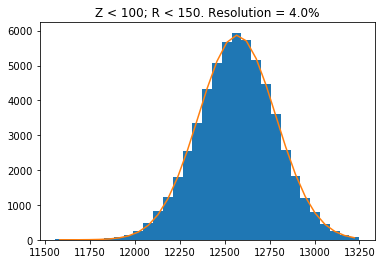

Fit a Gaussian with guess (A0, m0, s0) = (7659.0, 12537.093282646594, 1239.3573501957605)


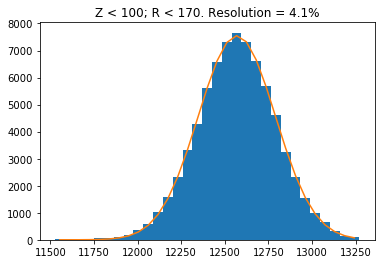

Fit a Gaussian with guess (A0, m0, s0) = (1420.0, 12439.146589785614, 1186.5379522082649)


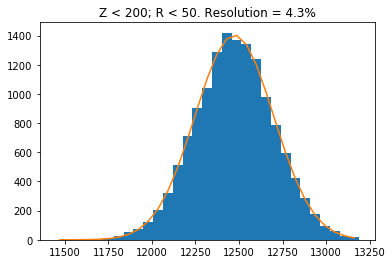

Fit a Gaussian with guess (A0, m0, s0) = (5580.0, 12447.590292063032, 1178.4929708832217)


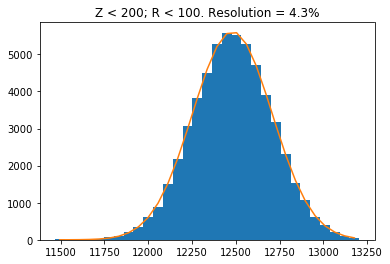

Fit a Gaussian with guess (A0, m0, s0) = (12829.0, 12448.155404798224, 1213.5978298500547)


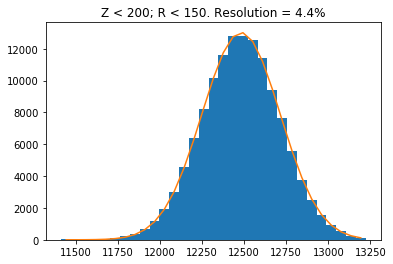

Fit a Gaussian with guess (A0, m0, s0) = (16785.0, 12447.096847524252, 1255.7425568026817)


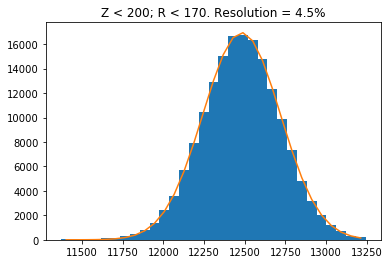

Fit a Gaussian with guess (A0, m0, s0) = (2146.0, 12358.919907152549, 1146.9777768844485)


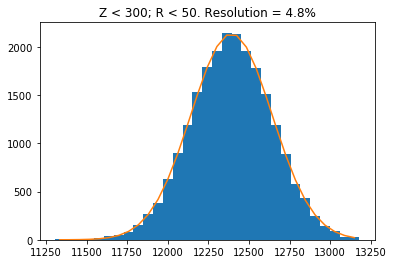

Fit a Gaussian with guess (A0, m0, s0) = (8734.0, 12362.257250291534, 1151.7456299317057)


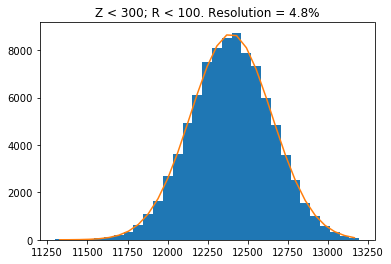

Fit a Gaussian with guess (A0, m0, s0) = (20056.0, 12360.73522612219, 1189.8141272042155)


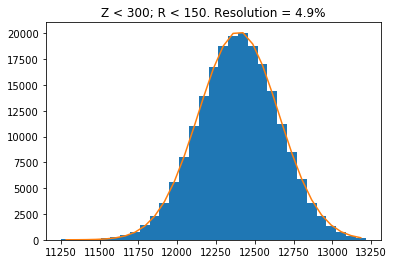

Fit a Gaussian with guess (A0, m0, s0) = (26246.0, 12358.685080582296, 1237.2666205373596)


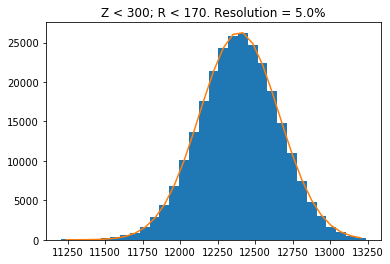

Fit a Gaussian with guess (A0, m0, s0) = (2826.0, 12273.594476453844, 1089.8488025355978)


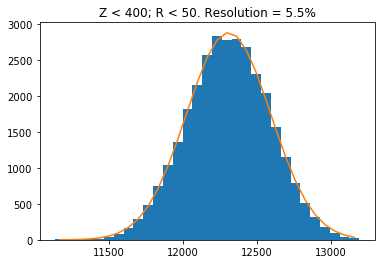

Fit a Gaussian with guess (A0, m0, s0) = (11486.0, 12276.743266482481, 1093.382427022233)


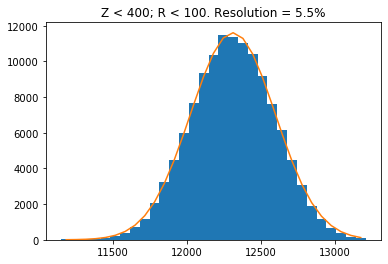

Fit a Gaussian with guess (A0, m0, s0) = (26669.0, 12275.822751845451, 1133.6181106823872)


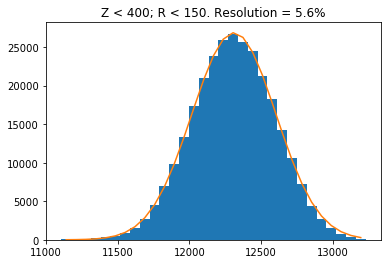

Fit a Gaussian with guess (A0, m0, s0) = (34722.0, 12273.097134886646, 1181.1035686549733)


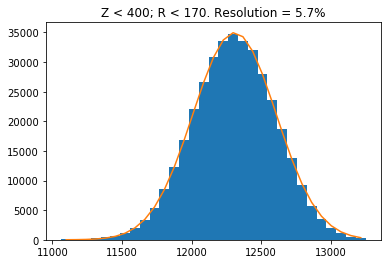

Fit a Gaussian with guess (A0, m0, s0) = (3535.0, 12187.391843125126, 1014.4389782636099)


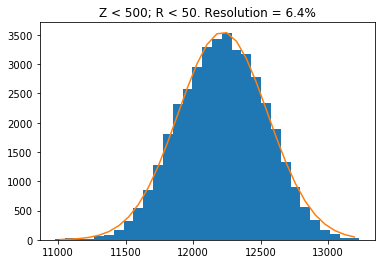

Fit a Gaussian with guess (A0, m0, s0) = (14258.0, 12191.423341548447, 1022.6025285943857)


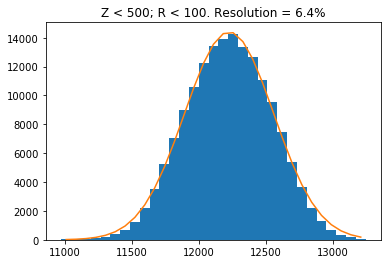

Fit a Gaussian with guess (A0, m0, s0) = (32449.0, 12188.437997667741, 1063.241484464132)


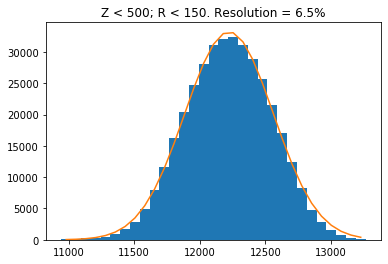

Fit a Gaussian with guess (A0, m0, s0) = (42075.0, 12185.602958481551, 1111.3862667738724)


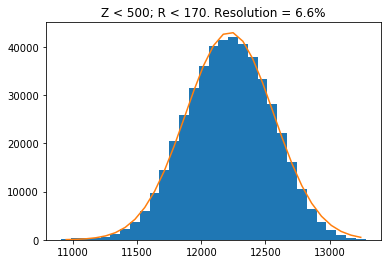

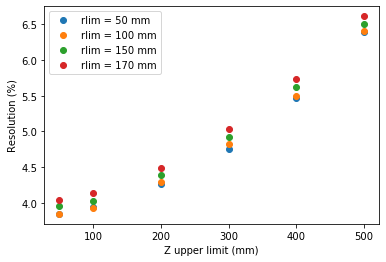

Innermost resolution =  3.85 %
Outermost resolution =  6.61 %


In [81]:
ezmask_72 = (kdstE_72 < 16000) & (kdstE_72 > 6000) & (Zrms_72 > 10)

corr_kdst_72 = geom_corr(kdstX_72[ezmask_72], kdstY_72[ezmask_72])
Ebootcorrs_kdst_72 = corr_kdst_72 * kdstE_72[ezmask_72]

boot_res_vs_zr_kdst_72 = fit_res_vs_zr_matched(Ebootcorrs_kdst_72, bounds_7472, kdstX_72[ezmask_72], kdstY_72[ezmask_72], Zrms_72[ezmask_72], show = True)
plot_res_vs_zr(boot_res_vs_zr_kdst_72)

In [82]:
print('Total time =', round(time() - t0 / 60, 1), 'm')

Total time = 1584909134.0 m


### Apply total (w/ LT) correction

In [83]:
from invisible_cities.reco.corrections       import apply_all_correction

In [144]:
# Check with Zrms
total_correction = apply_all_correction(bootstrap_map, apply_temp=False)
corr_tot_lt = total_correction(kdstX_72, kdstY_72, Zrms_72, all_kdsts_72.time)
Ebootcorrsall_kdst_72 = corr_tot_lt[ezmask_72] * kdstE_72[ezmask_72]

Fit a Gaussian with guess (A0, m0, s0) = (268.0, 12630.089029367484, 1229.3095201323877)


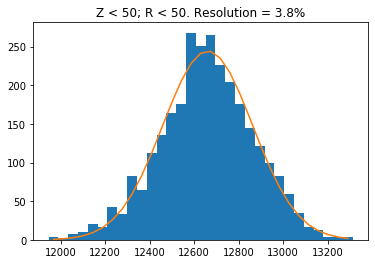

Fit a Gaussian with guess (A0, m0, s0) = (1027.0, 12631.048479419711, 1239.5362590926509)


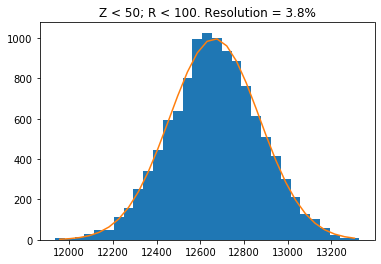

Fit a Gaussian with guess (A0, m0, s0) = (2243.0, 12630.07686850715, 1253.7725854611067)


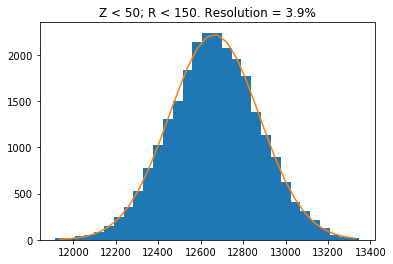

Fit a Gaussian with guess (A0, m0, s0) = (2854.0, 12629.472236871788, 1293.6768716453876)


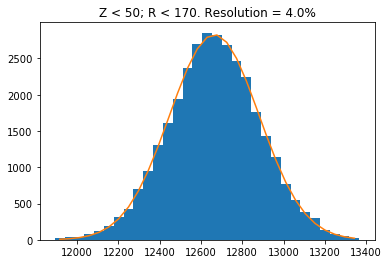

Fit a Gaussian with guess (A0, m0, s0) = (592.0, 12622.381397895868, 1215.6470480790804)


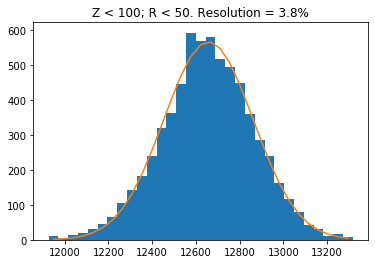

Fit a Gaussian with guess (A0, m0, s0) = (2280.0, 12631.299162272242, 1220.1134040106374)


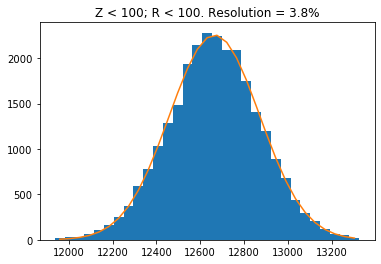

Fit a Gaussian with guess (A0, m0, s0) = (5196.0, 12633.481931539503, 1231.6769527886377)


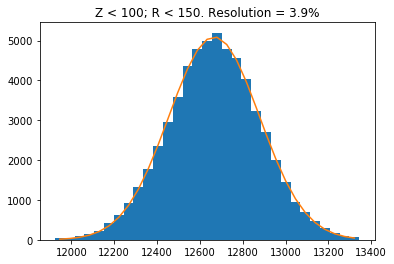

Fit a Gaussian with guess (A0, m0, s0) = (6610.0, 12633.116286047196, 1266.0745013999378)


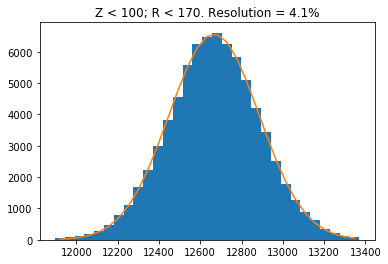

Fit a Gaussian with guess (A0, m0, s0) = (1230.0, 12625.984713865224, 1213.5029552235292)


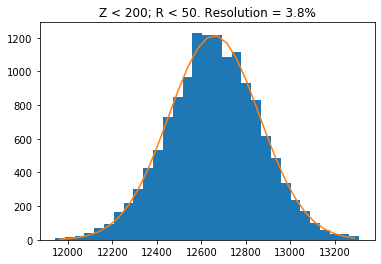

Fit a Gaussian with guess (A0, m0, s0) = (4939.0, 12633.276927034563, 1203.3506127936914)


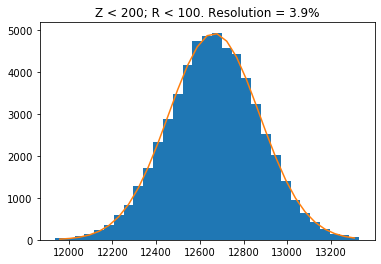

Fit a Gaussian with guess (A0, m0, s0) = (11210.0, 12635.745060800622, 1236.6611780137287)


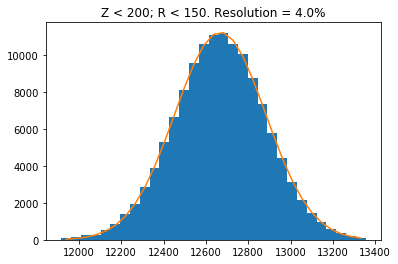

Fit a Gaussian with guess (A0, m0, s0) = (14605.0, 12636.239322692363, 1282.109974610223)


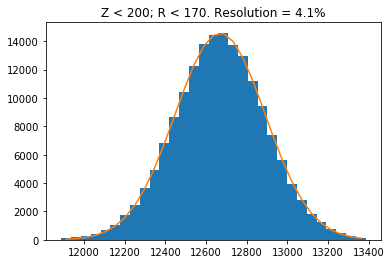

Fit a Gaussian with guess (A0, m0, s0) = (1983.0, 12631.746364221715, 1175.9690027273416)


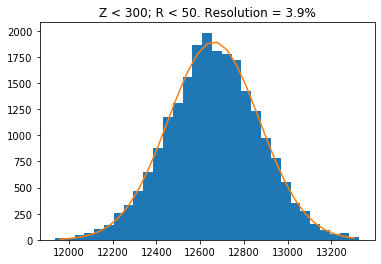

Fit a Gaussian with guess (A0, m0, s0) = (7772.0, 12637.03227204352, 1178.2405781419818)


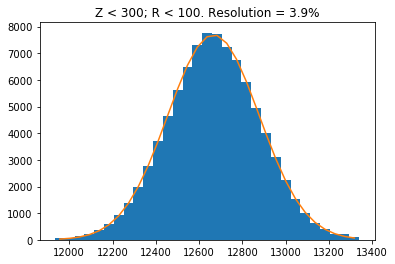

Fit a Gaussian with guess (A0, m0, s0) = (17768.0, 12639.79570074477, 1216.3285903768547)


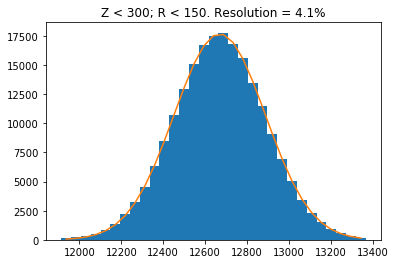

Fit a Gaussian with guess (A0, m0, s0) = (23039.0, 12640.631870983509, 1267.154652694057)


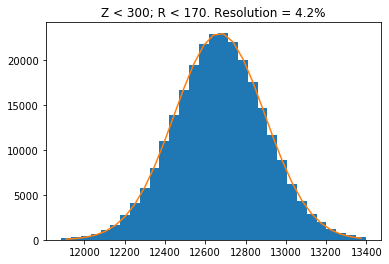

Fit a Gaussian with guess (A0, m0, s0) = (2613.0, 12638.994092093482, 1122.6156152557567)


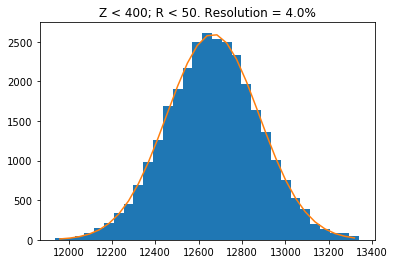

Fit a Gaussian with guess (A0, m0, s0) = (10654.0, 12644.064598379231, 1123.424543936208)


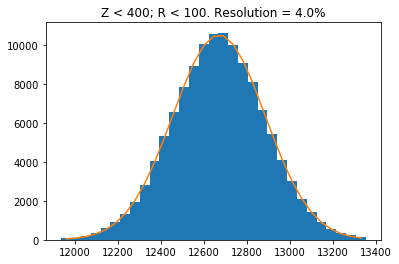

Fit a Gaussian with guess (A0, m0, s0) = (24196.0, 12646.454991935108, 1164.978468737909)


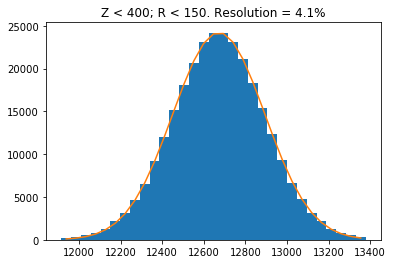

Fit a Gaussian with guess (A0, m0, s0) = (31438.0, 12647.013895764585, 1215.5203952058048)


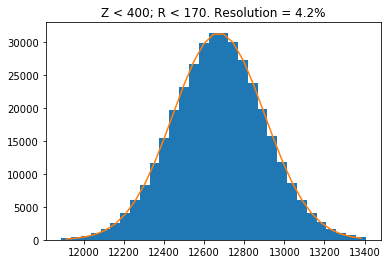

Fit a Gaussian with guess (A0, m0, s0) = (3348.0, 12644.605121663322, 1048.4818563392719)


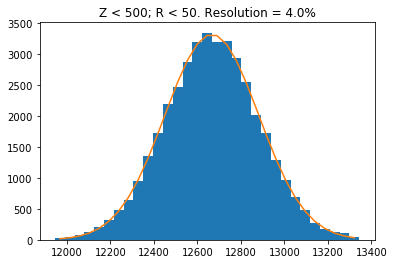

Fit a Gaussian with guess (A0, m0, s0) = (13551.0, 12647.810584961155, 1053.893077934687)


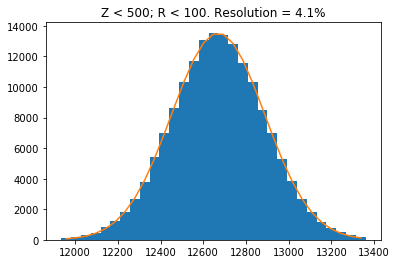

Fit a Gaussian with guess (A0, m0, s0) = (30927.0, 12650.357512675095, 1095.3887008428187)


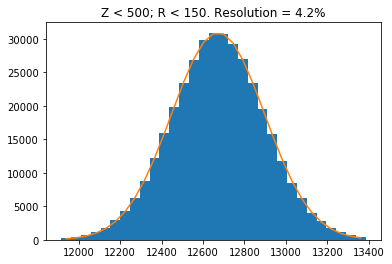

Fit a Gaussian with guess (A0, m0, s0) = (40146.0, 12651.212540919409, 1146.911052777217)


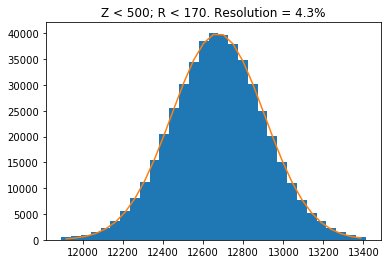

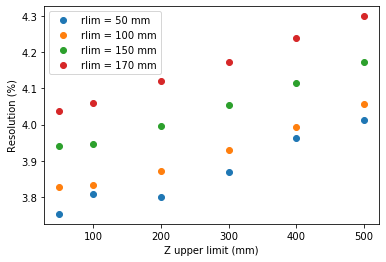

Innermost resolution =  3.75 %
Outermost resolution =  4.3 %


In [145]:
boot_res_vs_zr_kdst_72 = fit_res_vs_zr_matched(Ebootcorrsall_kdst_72, bounds_7472, kdstX_72[ezmask_72], kdstY_72[ezmask_72], Zrms_72[ezmask_72], show = True)
plot_res_vs_zr(boot_res_vs_zr_kdst_72)

In [140]:
# Check with ZS1
ezmask_72 = (kdstE_72 < 16000) & (kdstE_72 > 6000) & (ZS1_72 > 10)

total_correction = apply_all_correction(bootstrap_map, apply_temp=False)
corr_tot_lt = total_correction(kdstX_72, kdstY_72, ZS1_72, all_kdsts_72.time)
Ebootcorrsall_kdst_72 = corr_tot_lt[ezmask_72] * kdstE_72[ezmask_72]

Fit a Gaussian with guess (A0, m0, s0) = (274.0, 12506.73803936053, 1648.0262399936564)


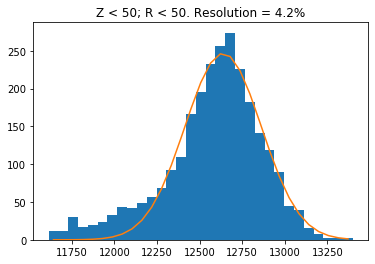

Fit a Gaussian with guess (A0, m0, s0) = (1055.0, 12512.96755036679, 1667.1078809180576)


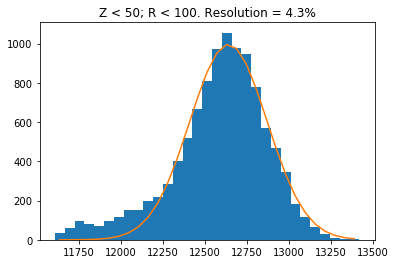

Fit a Gaussian with guess (A0, m0, s0) = (2334.0, 12510.142346268485, 1695.0237089406644)


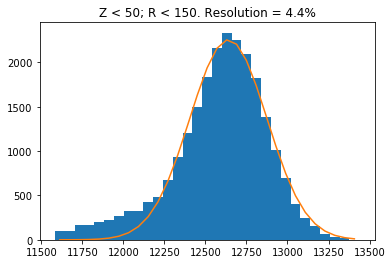

Fit a Gaussian with guess (A0, m0, s0) = (2956.0, 12507.975763998615, 1731.1556341162075)


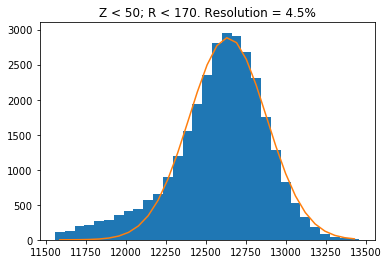

Fit a Gaussian with guess (A0, m0, s0) = (567.0, 12548.35972079892, 1450.0570686661422)


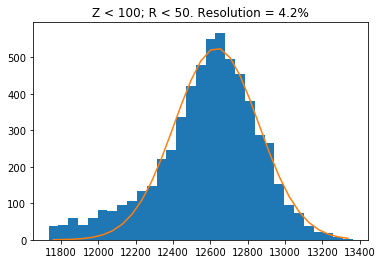

Fit a Gaussian with guess (A0, m0, s0) = (2160.0, 12558.722391561538, 1465.63103150871)


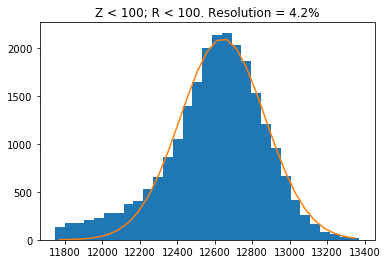

Fit a Gaussian with guess (A0, m0, s0) = (4916.0, 12558.523975764272, 1490.6026711651998)


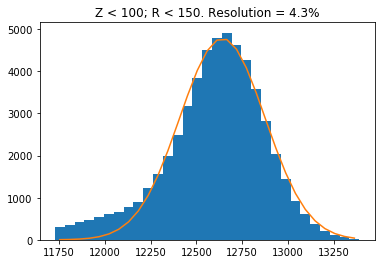

Fit a Gaussian with guess (A0, m0, s0) = (6296.0, 12556.424540677424, 1525.2765642406455)


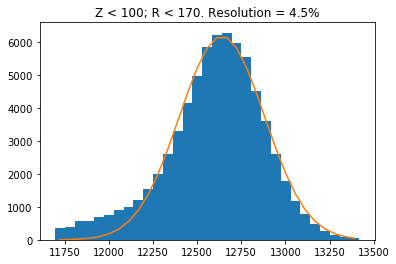

Fit a Gaussian with guess (A0, m0, s0) = (1174.0, 12583.959177727787, 1285.802264732948)


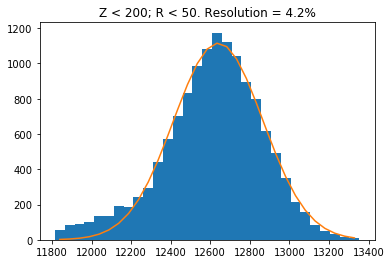

Fit a Gaussian with guess (A0, m0, s0) = (4661.0, 12588.923463955218, 1296.265978019048)


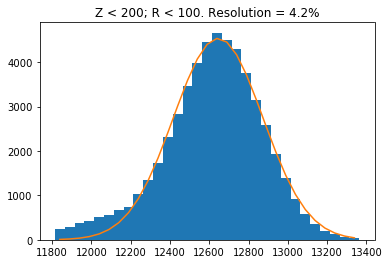

Fit a Gaussian with guess (A0, m0, s0) = (10602.0, 12590.159772063815, 1328.4374866464166)


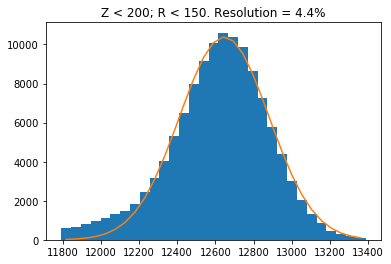

Fit a Gaussian with guess (A0, m0, s0) = (13745.0, 12589.523974616652, 1374.6603112892828)


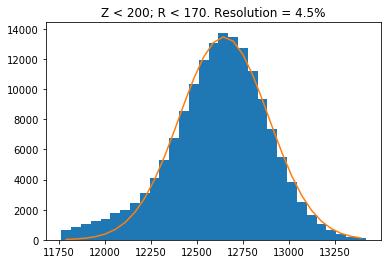

Fit a Gaussian with guess (A0, m0, s0) = (1783.0, 12606.51471634277, 1199.2932339518113)


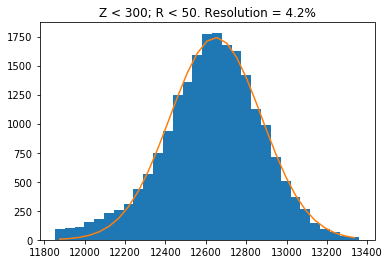

Fit a Gaussian with guess (A0, m0, s0) = (7222.0, 12608.55557371094, 1209.333730695829)


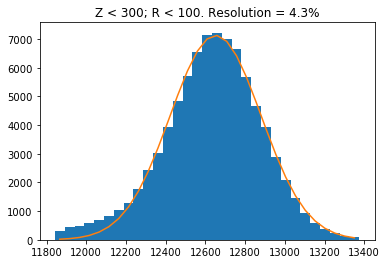

Fit a Gaussian with guess (A0, m0, s0) = (16653.0, 12610.21615803976, 1250.8078625182666)


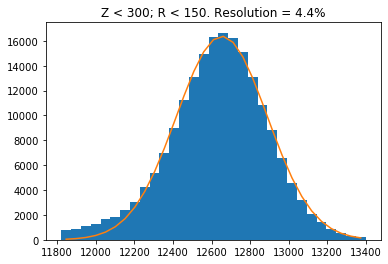

Fit a Gaussian with guess (A0, m0, s0) = (21621.0, 12610.069333249474, 1300.4267950945534)


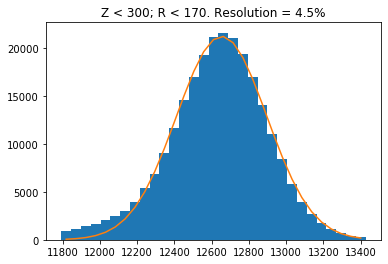

Fit a Gaussian with guess (A0, m0, s0) = (2465.0, 12623.5386912172, 1127.614014238172)


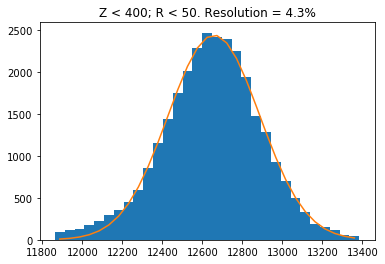

Fit a Gaussian with guess (A0, m0, s0) = (10046.0, 12625.23471975894, 1137.3019041463665)


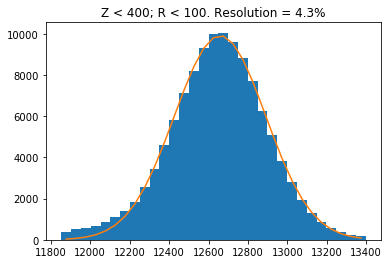

Fit a Gaussian with guess (A0, m0, s0) = (23096.0, 12626.835125278623, 1179.3602464728574)


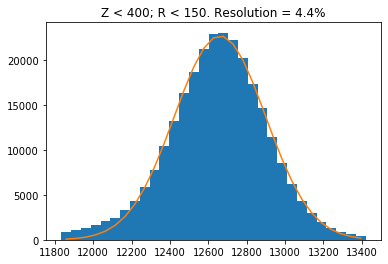

Fit a Gaussian with guess (A0, m0, s0) = (29951.0, 12627.248300727682, 1231.730289658844)


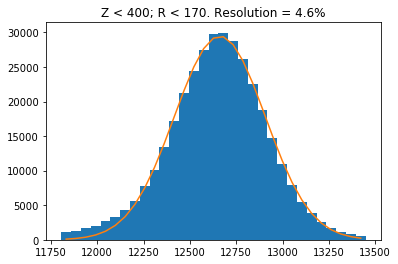

Fit a Gaussian with guess (A0, m0, s0) = (3231.0, 12634.185101502997, 1060.7929312011759)


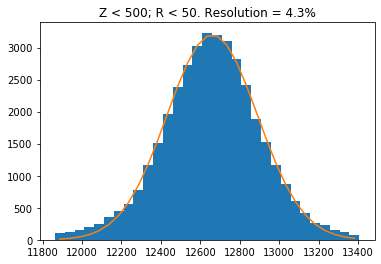

Fit a Gaussian with guess (A0, m0, s0) = (13099.0, 12637.445927391973, 1067.641857171912)


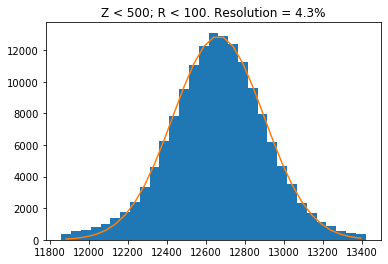

Fit a Gaussian with guess (A0, m0, s0) = (30054.0, 12639.867132648813, 1110.0898776688596)


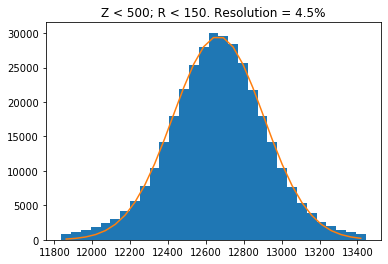

Fit a Gaussian with guess (A0, m0, s0) = (38904.0, 12640.451810093726, 1162.7687820874432)


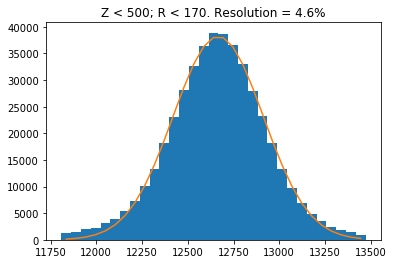

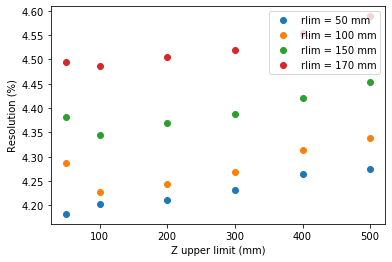

Innermost resolution =  4.18 %
Outermost resolution =  4.59 %


In [143]:
boot_res_vs_zr_kdst_72 = fit_res_vs_zr_matched(Ebootcorrsall_kdst_72, bounds_7472, kdstX_72[ezmask_72], kdstY_72[ezmask_72], ZS1_72[ezmask_72], show = True)
plot_res_vs_zr(boot_res_vs_zr_kdst_72)

In [149]:
# Check with ZS1, fixed
fixed_ZS1 = []
for ZS1, Zrms in zip(ZS1_72, Zrms_72):
    if abs(ZS1 - Zrms) > 50:
        fixed_ZS1.append(Zrms)
    else:
        fixed_ZS1.append(ZS1)
fixed_ZS1 = np.array(fixed_ZS1)

In [150]:
ezmask_72 = (kdstE_72 < 16000) & (kdstE_72 > 6000) & (fixed_ZS1 > 10)

total_correction = apply_all_correction(bootstrap_map, apply_temp=False)
corr_tot_lt = total_correction(kdstX_72, kdstY_72, fixed_ZS1, all_kdsts_72.time)
Ebootcorrsall_kdst_72 = corr_tot_lt[ezmask_72] * kdstE_72[ezmask_72]

Fit a Gaussian with guess (A0, m0, s0) = (257.0, 12631.33610674559, 1224.113610797916)


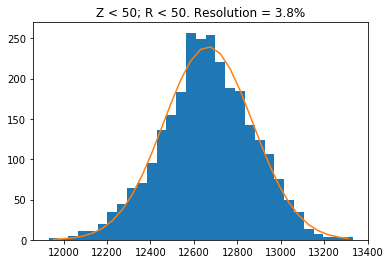

Fit a Gaussian with guess (A0, m0, s0) = (1008.0, 12631.999636681001, 1254.950949260428)


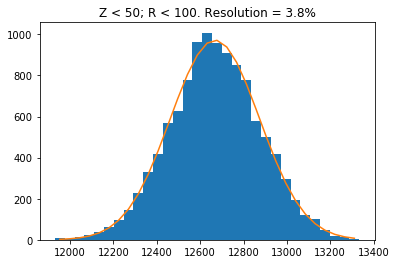

Fit a Gaussian with guess (A0, m0, s0) = (2204.0, 12632.118668347193, 1250.4451627276965)


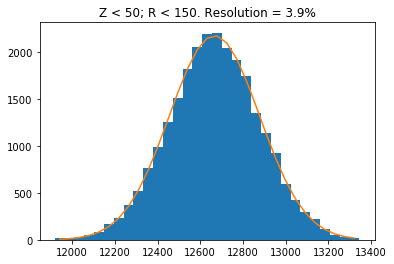

Fit a Gaussian with guess (A0, m0, s0) = (2847.0, 12631.543285372958, 1278.8497941278722)


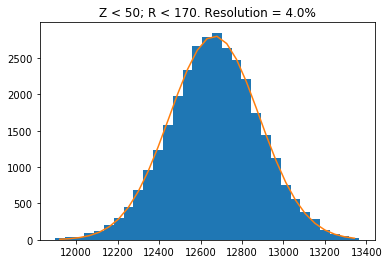

Fit a Gaussian with guess (A0, m0, s0) = (565.0, 12625.852114797173, 1182.389942761048)


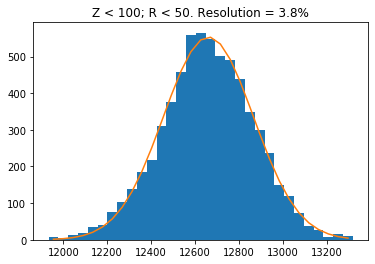

Fit a Gaussian with guess (A0, m0, s0) = (2223.0, 12635.605779336658, 1195.3962644730464)


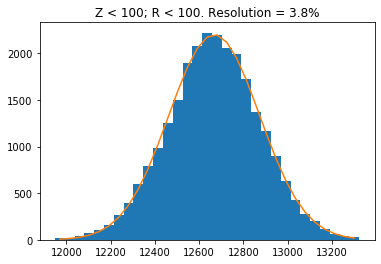

Fit a Gaussian with guess (A0, m0, s0) = (5054.0, 12637.032032698286, 1210.6940140409108)


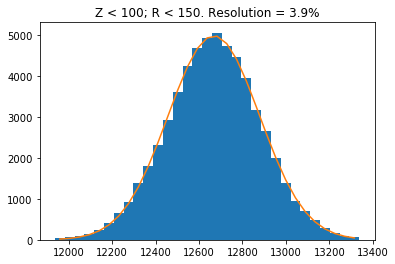

Fit a Gaussian with guess (A0, m0, s0) = (6517.0, 12636.210298641206, 1240.1268789127594)


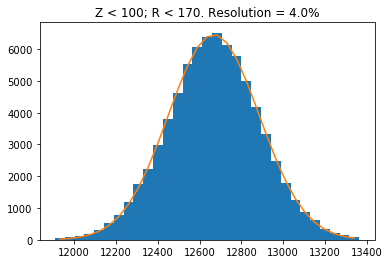

Fit a Gaussian with guess (A0, m0, s0) = (1243.0, 12628.095173672273, 1192.065219328369)


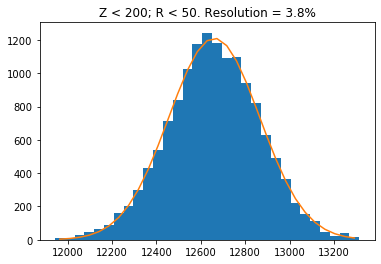

Fit a Gaussian with guess (A0, m0, s0) = (4902.0, 12635.952966709245, 1186.6940239672608)


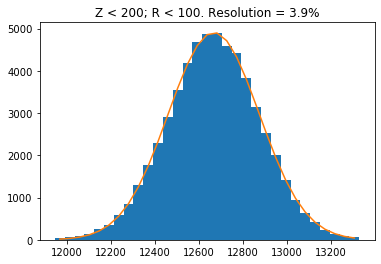

Fit a Gaussian with guess (A0, m0, s0) = (11238.0, 12637.935461298393, 1220.7263705851726)


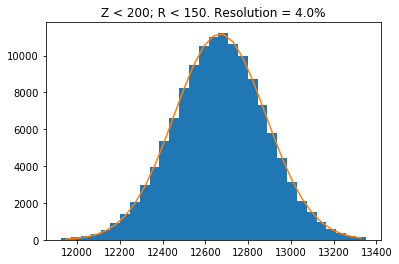

Fit a Gaussian with guess (A0, m0, s0) = (14504.0, 12638.135349242048, 1265.5359034731273)


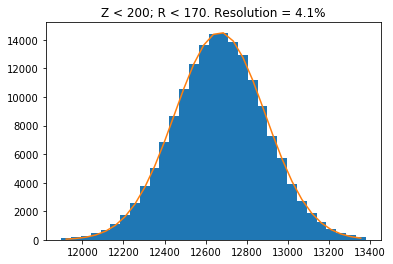

Fit a Gaussian with guess (A0, m0, s0) = (1992.0, 12633.745089840428, 1159.9042397689918)


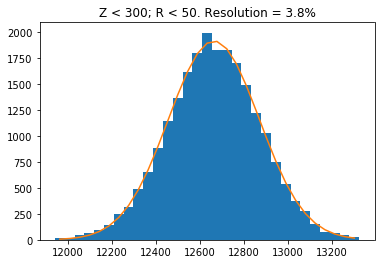

Fit a Gaussian with guess (A0, m0, s0) = (7782.0, 12639.7682836953, 1164.7287600389302)


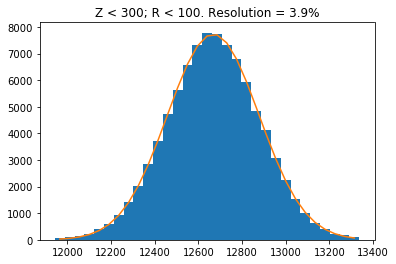

Fit a Gaussian with guess (A0, m0, s0) = (17822.0, 12641.528468982888, 1205.693930287344)


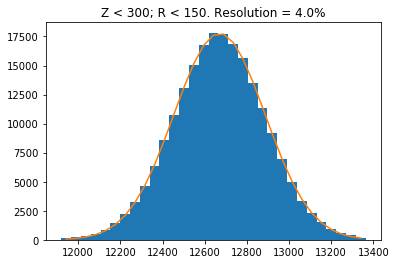

Fit a Gaussian with guess (A0, m0, s0) = (23233.0, 12641.934281618962, 1255.8194997107546)


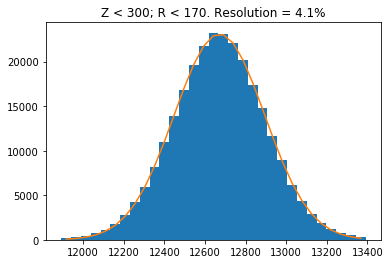

Fit a Gaussian with guess (A0, m0, s0) = (2641.0, 12642.150357213339, 1108.1552101932186)


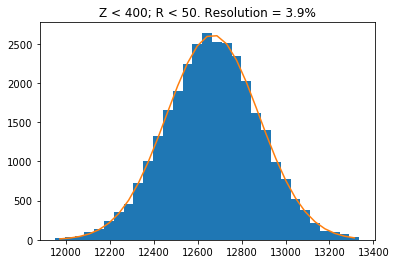

Fit a Gaussian with guess (A0, m0, s0) = (10695.0, 12645.826883120833, 1114.278136162818)


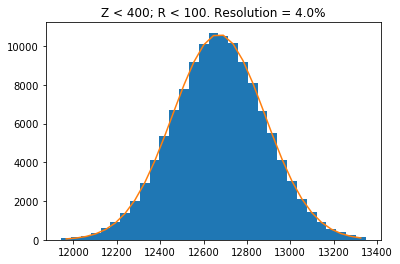

Fit a Gaussian with guess (A0, m0, s0) = (24597.0, 12647.268567804205, 1156.0364254661504)


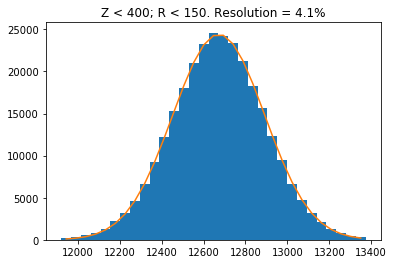

Fit a Gaussian with guess (A0, m0, s0) = (31980.0, 12647.673341909596, 1206.4465446947347)


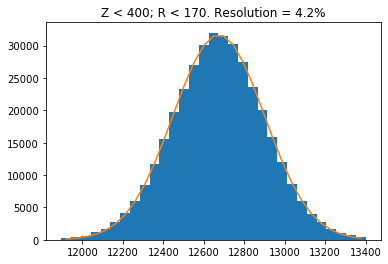

Fit a Gaussian with guess (A0, m0, s0) = (3405.0, 12645.74542566045, 1040.5070185976347)


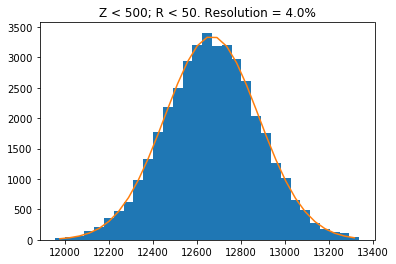

Fit a Gaussian with guess (A0, m0, s0) = (13681.0, 12649.059846112628, 1047.2182656658804)


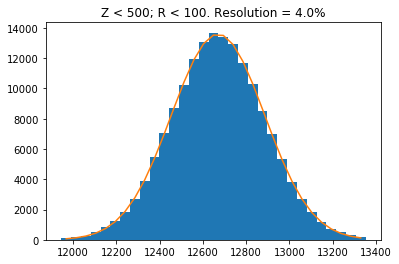

Fit a Gaussian with guess (A0, m0, s0) = (31248.0, 12650.77493840411, 1089.2717803946045)


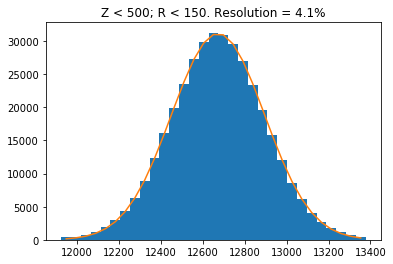

Fit a Gaussian with guess (A0, m0, s0) = (40548.0, 12651.546125587864, 1141.0427428464388)


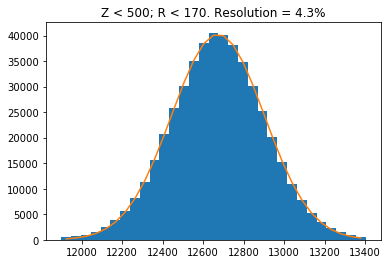

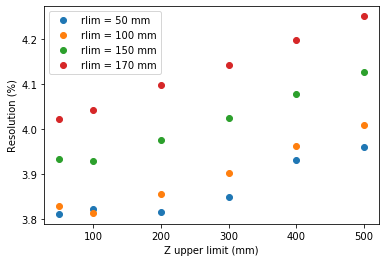

Innermost resolution =  3.81 %
Outermost resolution =  4.25 %


In [151]:
boot_res_vs_zr_kdst_72 = fit_res_vs_zr_matched(Ebootcorrsall_kdst_72, bounds_7472, kdstX_72[ezmask_72], kdstY_72[ezmask_72], fixed_ZS1[ezmask_72], show = True)
plot_res_vs_zr(boot_res_vs_zr_kdst_72)

In [ ]:
## Compare Zrms and ZS1

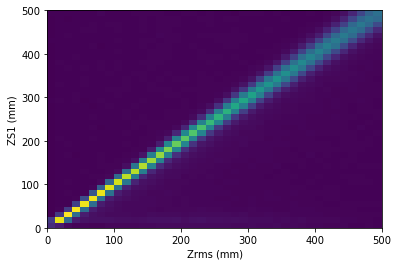

In [95]:
plt.hist2d(Zrms_72, ZS1_72, range = ((0, 500), (0, 500)), bins = 40)
plt.xlabel('Zrms (mm)')
plt.ylabel('ZS1 (mm)')
plt.show()

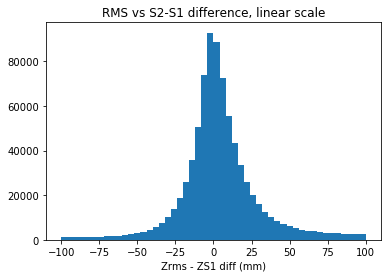

In [110]:
plt.hist(Zrms_72-ZS1_72, range = (-100, 100), bins = 50)
plt.xlabel('Zrms - ZS1 diff (mm)')
plt.title('RMS vs S2-S1 difference, linear scale')
plt.show()

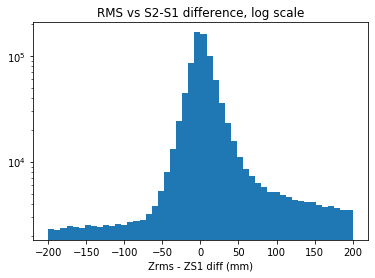

In [109]:
plt.hist(Zrms_72-ZS1_72, range = (-200, 200), bins = 50)
plt.yscale('log')
plt.xlabel('Zrms - ZS1 diff (mm)')
plt.title('RMS vs S2-S1 difference, log scale')
plt.show()

In [148]:
diff_rmss1 = Zrms_72-ZS1_72
diffabs_rmss1 = ((Zrms_72-ZS1_72)**2)**0.5
diffcut = diffabs_rmss1 < 500

print('WITHOUT DIFFERENCE CUT')
print('Mean difference:', round(np.mean(diff_rmss1),1))
print('Median difference:', round(np.median(diff_rmss1),1))
print('Mean abs difference:', round(np.mean(diffabs_rmss1),1))
print('Median abs difference:', round(np.median(diffabs_rmss1),1))

print('\nWITH DIFFERENCE CUT [abs(Zrms - ZS1) < 500]')
print('Mean difference:', round(np.mean(diff_rmss1[diffcut]),1))
print('Median difference:', round(np.median(diff_rmss1[diffcut]),1))
print('Mean abs difference:', round(np.mean(diffabs_rmss1[diffcut]),1))
print('Median abs difference:', round(np.median(diffabs_rmss1[diffcut]),1))
stdhi = np.percentile(diff_rmss1[diffcut], 50 + 68/2) - np.median(diff_rmss1[diffcut])
stdlo = np.percentile(diff_rmss1[diffcut], 50 - 68/2) - np.median(diff_rmss1[diffcut])
print('One sigma range =', stdlo, stdhi)

WITHOUT DIFFERENCE CUT
Mean difference: -50193.8
Median difference: 2.2
Mean abs difference: 50314.3
Median abs difference: 18.6

WITH DIFFERENCE CUT [abs(Zrms - ZS1) < 500]
Mean difference: 7.8
Median difference: 2.3
Mean abs difference: 72.3
Median abs difference: 16.3
One sigma range = -26.682079804561294 53.53069621631387


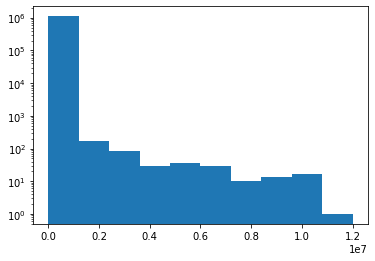

In [128]:
plt.hist(((Zrms_72-ZS1_72)**2)**0.5, range = (0, 12000000))
plt.yscale('log')
plt.show()